# 0.0 IMPORTS

In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor


## 0.1 Helper Funcitions

In [3]:
#função que calcula o cramer v de cada varriavel categorica
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#Função para configurar visualização dos boxplot em tamanho légivel
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [4]:
jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory=False )

# Merge dos datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Função lambda que transforma colunas em novos nomes snakecase
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ))

# Rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print( 'Número de linhas: {}'.format( df1.shape[0]))
print( 'Número de Colunas: {}'.format( df1.shape[1]))

Número de linhas: 1017209
Número de Colunas: 18


## 1.3 Data Types

In [9]:
#Transforma coluna date em formato de data
df1['date'] = pd.to_datetime( df1['date'] )

# Método que retorna tipos da colunas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
#Retorna soma dos dados faltantes
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance: Premissa(Se não existe um competidor próximo é por que está muito distante do mais próximo para ser considerado competidor)
#Aplica uma função lambda que substitui NA por 200000.0 (Valor maior que o dobro da maior distancia do dataset)
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.00 if math.isnan( x ) else x)
              
#competition_open_since_month
#Aplica uma função lambda que substitui NA pela mês da data de venda.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
#Aplica uma função lambda que substitui NA ano da data de venda.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
     
#promo2_since_week
#Substitui os dados faltantes pela semana da data de venda.
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
#Substitui os dados faltantes pelo ano da data de venda.
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
            
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

# Fillna para substituir NA por 0 direto na coluna
df1['promo_interval'].fillna(0, inplace=True)

#
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)




## 1.6 Change Types

In [13]:
#Modifica tipo das colunas
#competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
#promo 2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [14]:
#Separa as variaveis numericas e categoricas
num_atributes = df1.select_dtypes( include=['int64', 'float64', 'int32'])
cat_atributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])

## 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_atributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis. skew() kurtosis()
d1 = pd.DataFrame( num_atributes.apply( np.std )).T
d2 = pd.DataFrame( num_atributes.apply( min )).T
d3 = pd.DataFrame( num_atributes.apply( max )).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Atributes

In [16]:
#Quantidades de níveis de cada variavel categorica
cat_atributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

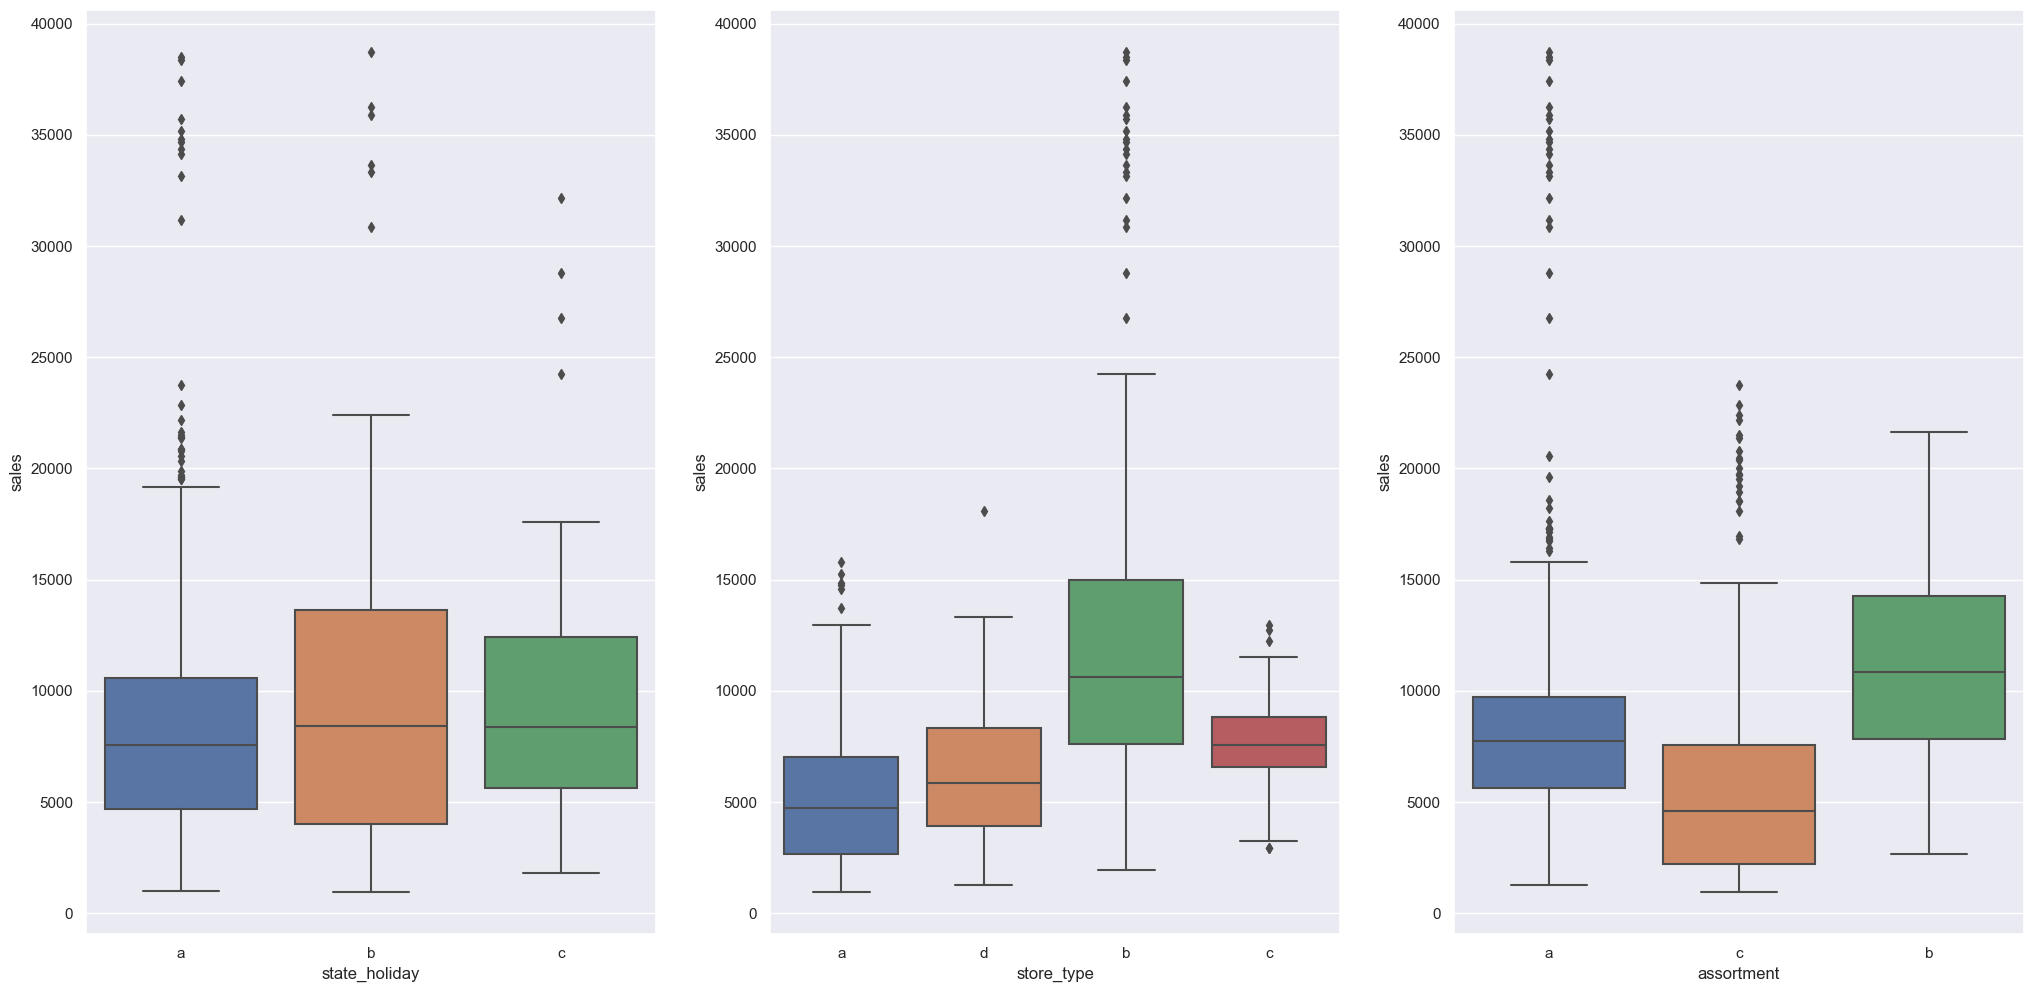

In [17]:
# Filtra que elimina dias que a loja está fechada e com vendas maiores que 0
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

#Plato as 3 boxplots para cada variavel juntas
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 PASSO 02 - FEATURE ENGINNERING

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses


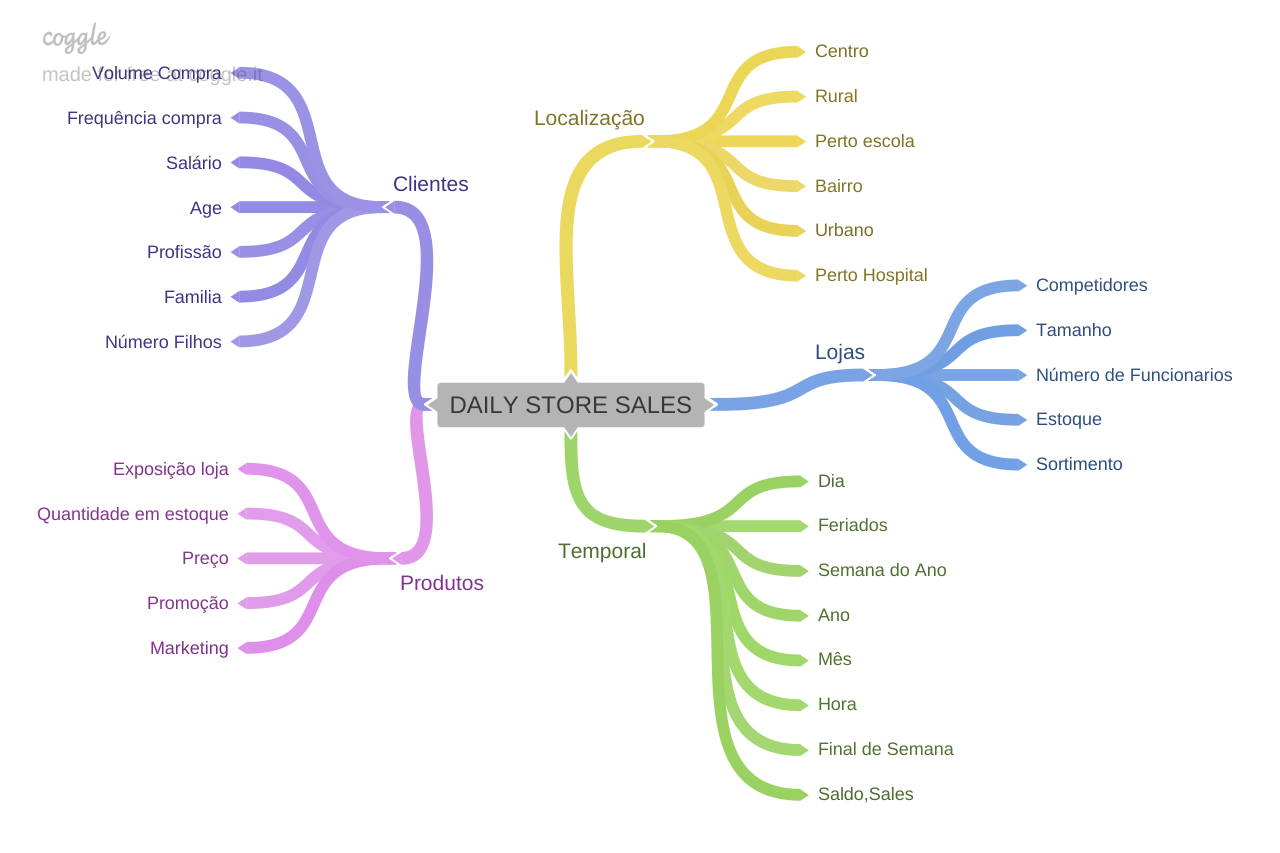

In [19]:
Image( 'img/Mindmap.png' )

## 2.2 Criacao de Hipoteses

### 2.2.1 Hipoteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


### 2.4 Feature Engineering

In [20]:
# year
#Utiliza método datatime (dt) para transformar data em ano
df2['year'] = df2['date'].dt.year 

# mounth
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
#Muda formatação da data por meio do strftime
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# aplica uma função que une ano e mês de competition, depois subtrai da data atual com a competição e transforma em dias 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) /30 ).apply( lambda x: x.days ).astype( int )

# promo since
# Une promoção anual e semanal em formato str
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# Converte str para data em formato Ano/semana do ano e subscreve na coluna promo_since
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
#Subtraia a data pela promo_since em semanas no formato int
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
#Cria uma condição que converte a,b,c da coluna assortment em suas definições
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

# State holiday
#Cria uma condição que converte a,b,c da coluna state holiday em suas definições
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c'else 'regular_day' )


C:\Users\yago2\AppData\Local\Temp\ipykernel_11820\836059952.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [21]:
df3 = df2.copy()

### 3.1 Filtragem das Linhas

In [22]:
#Filtra apenas valores em que as lojas estiveram abertas e houve vendas
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0 )]

### 3.2 Selecao das Colunas

In [23]:
#Elimina por meio do drop as colunas irrelevantes para o modelo
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [24]:
df4 = df3.copy()

### 4.1 Analise Univariada

#### 4.1.1 Variavel Resposta

<Axes: xlabel='sales', ylabel='Count'>

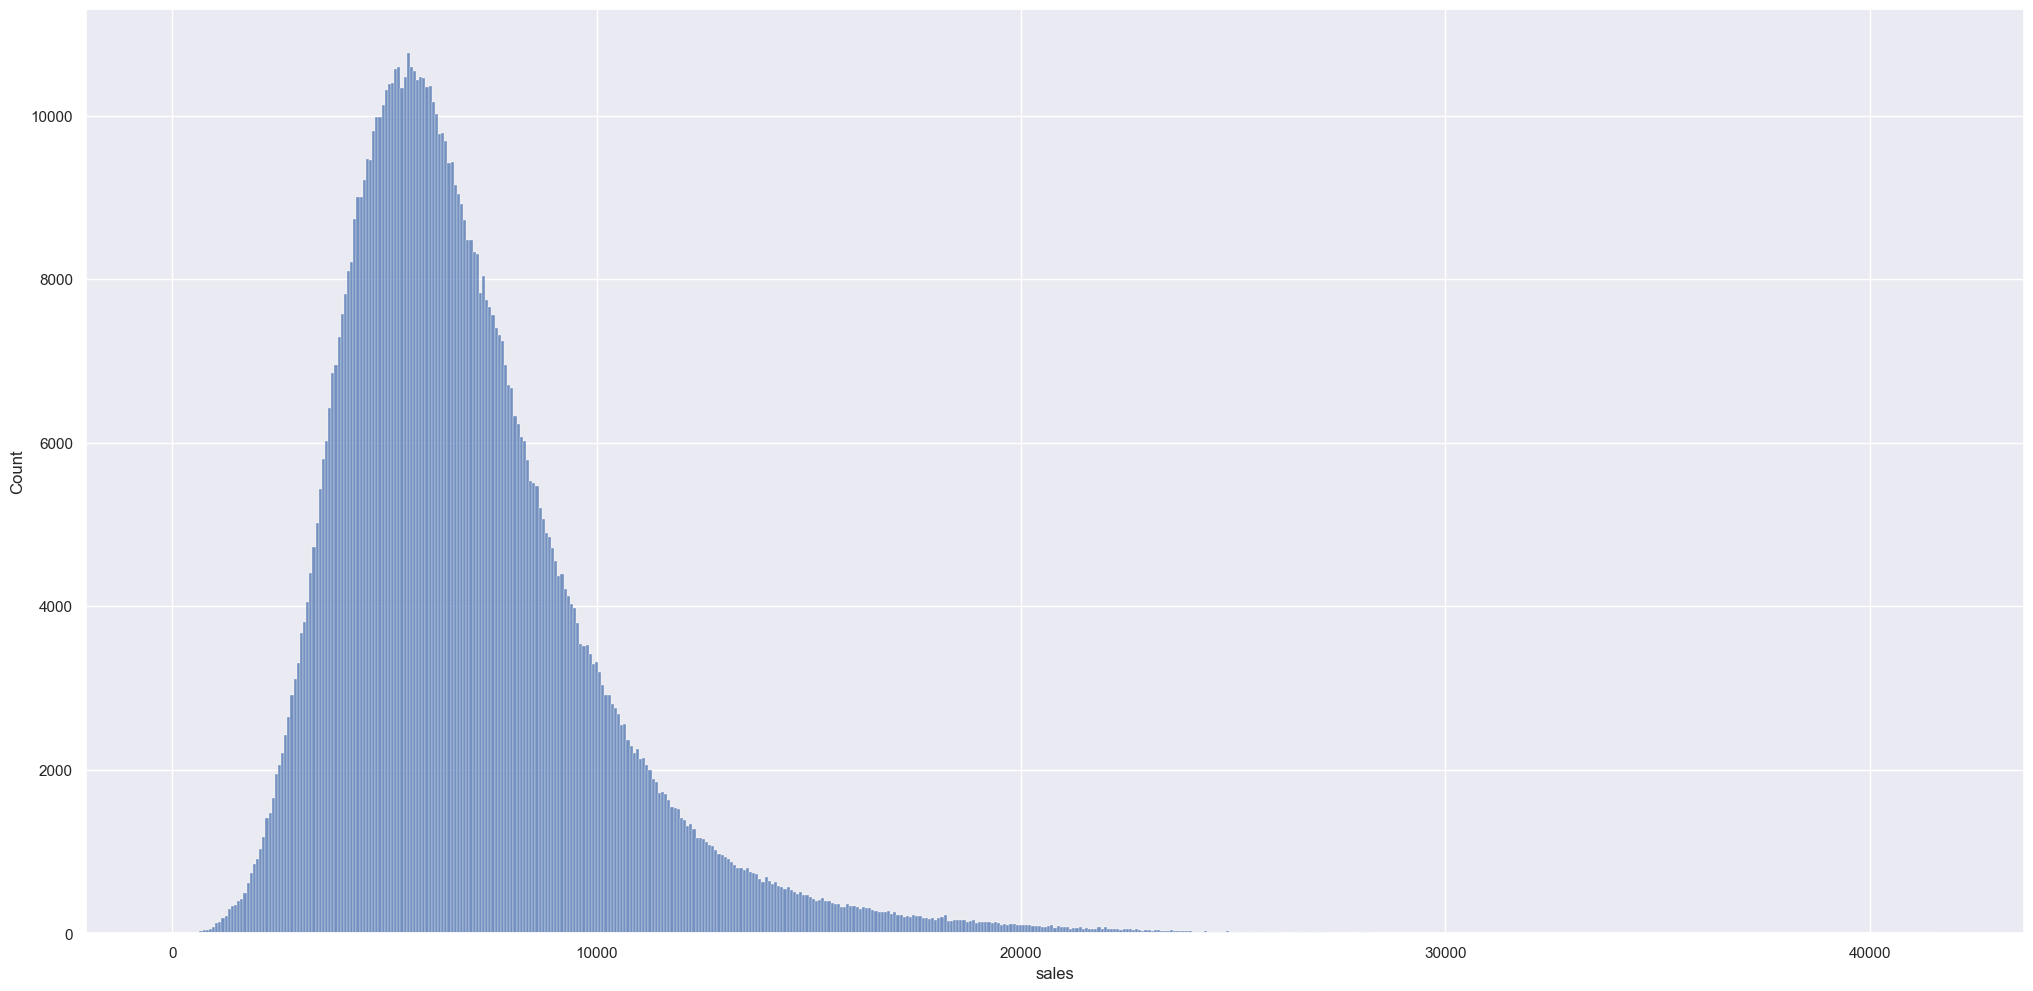

In [25]:
# Plota histograma utilizando biblioteca Seaborn
sns.histplot( df4['sales'] )

#### 4.1.2 Variavel Numerica

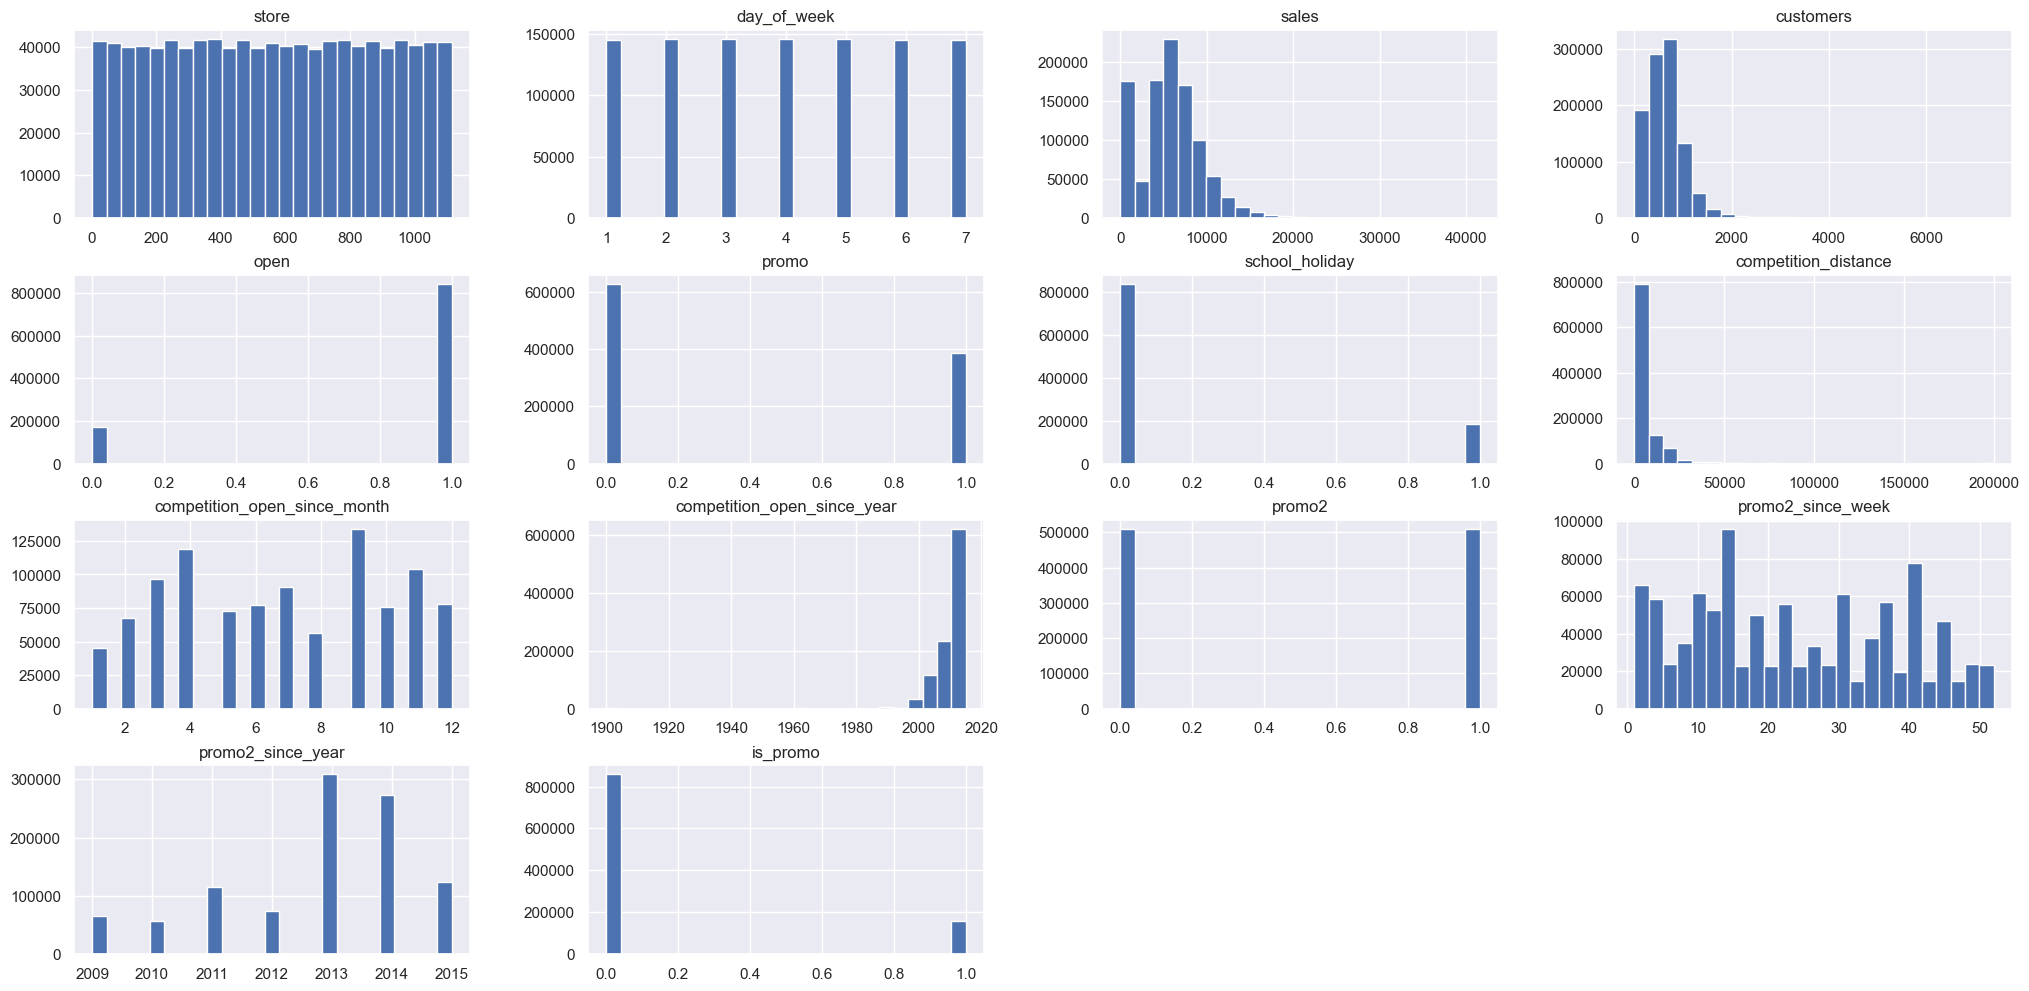

In [26]:
# Utiliza método .hist() para obter histograma de todas variaveis numericas
num_atributes.hist( bins=25);

#### 4.1.3 Variavel Categorica

In [27]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

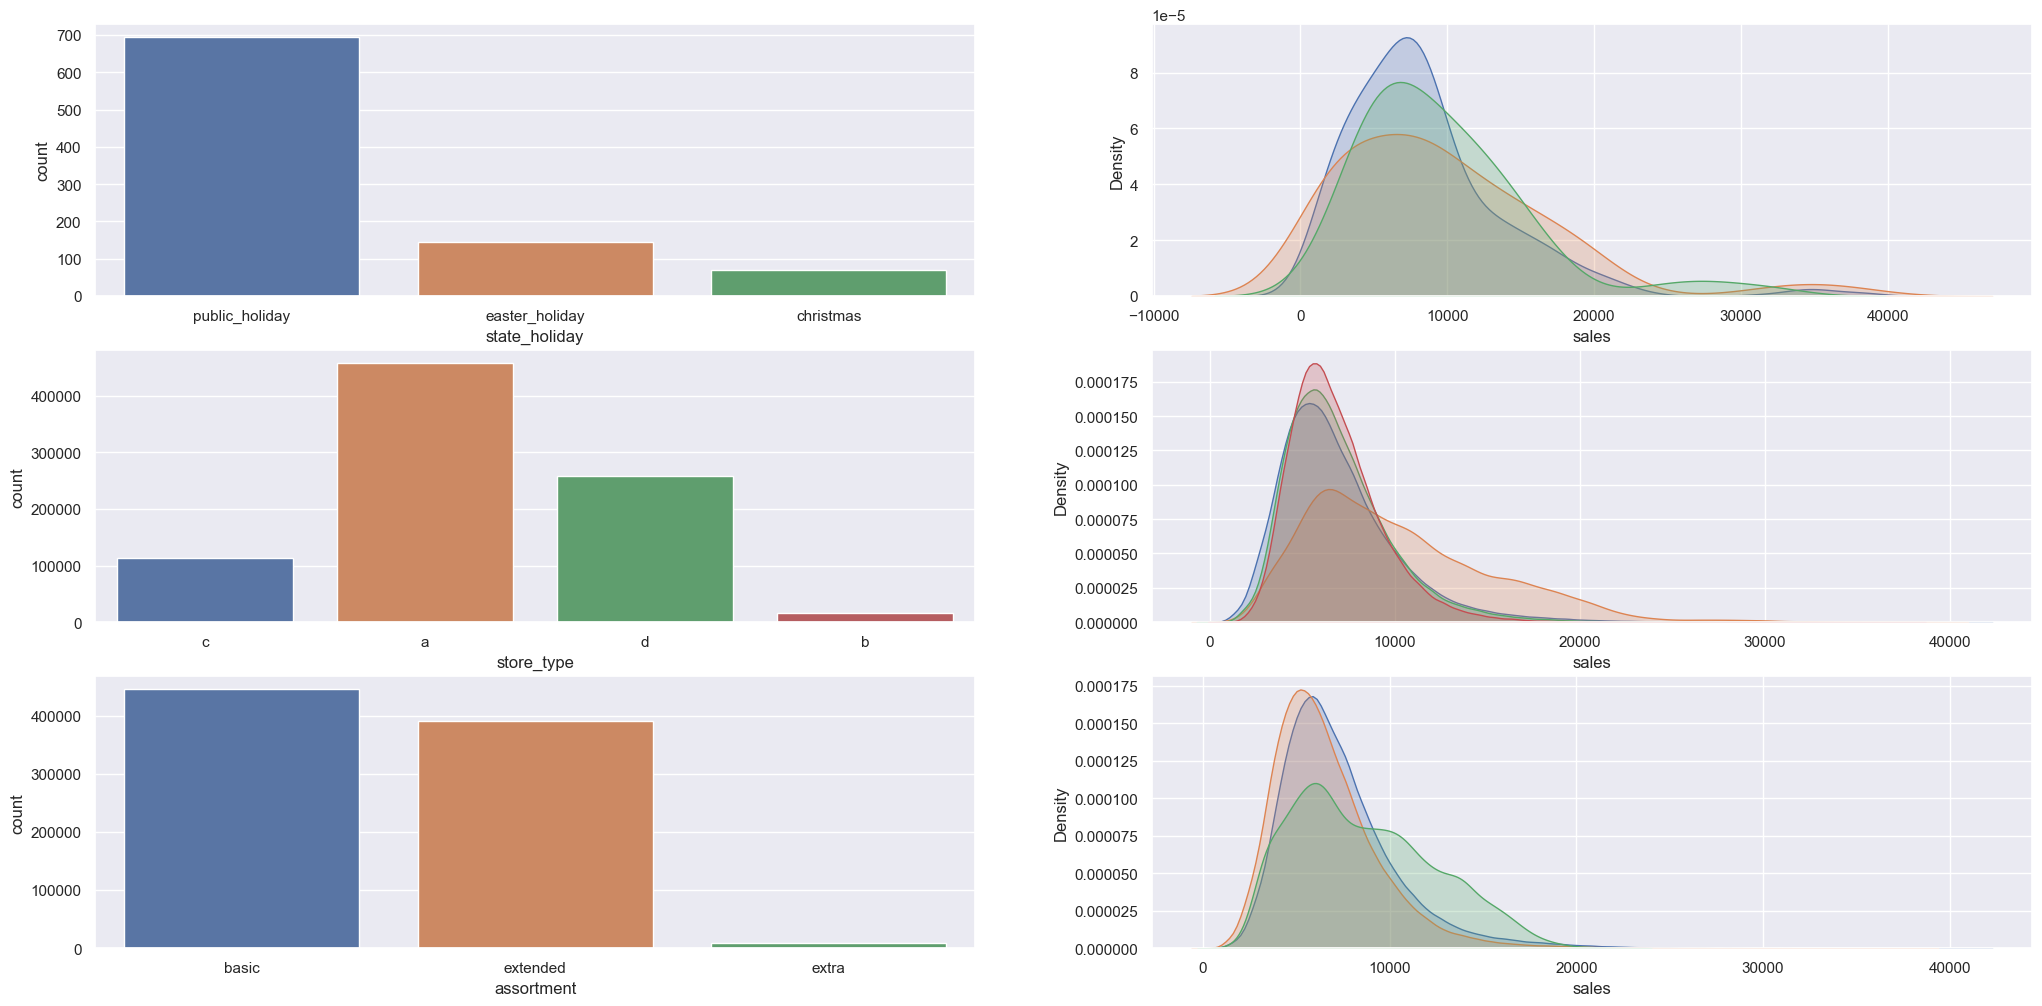

In [28]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day'] 
sns.countplot(data=a, x='state_holiday')

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( data=df4, x='store_type')
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data=df4,  x='assortment')
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra' , fill=True )

### 4.2 Analise Bivariada

#### H1.Lojas com maior sortimentos deveriam vender mais.
 FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.

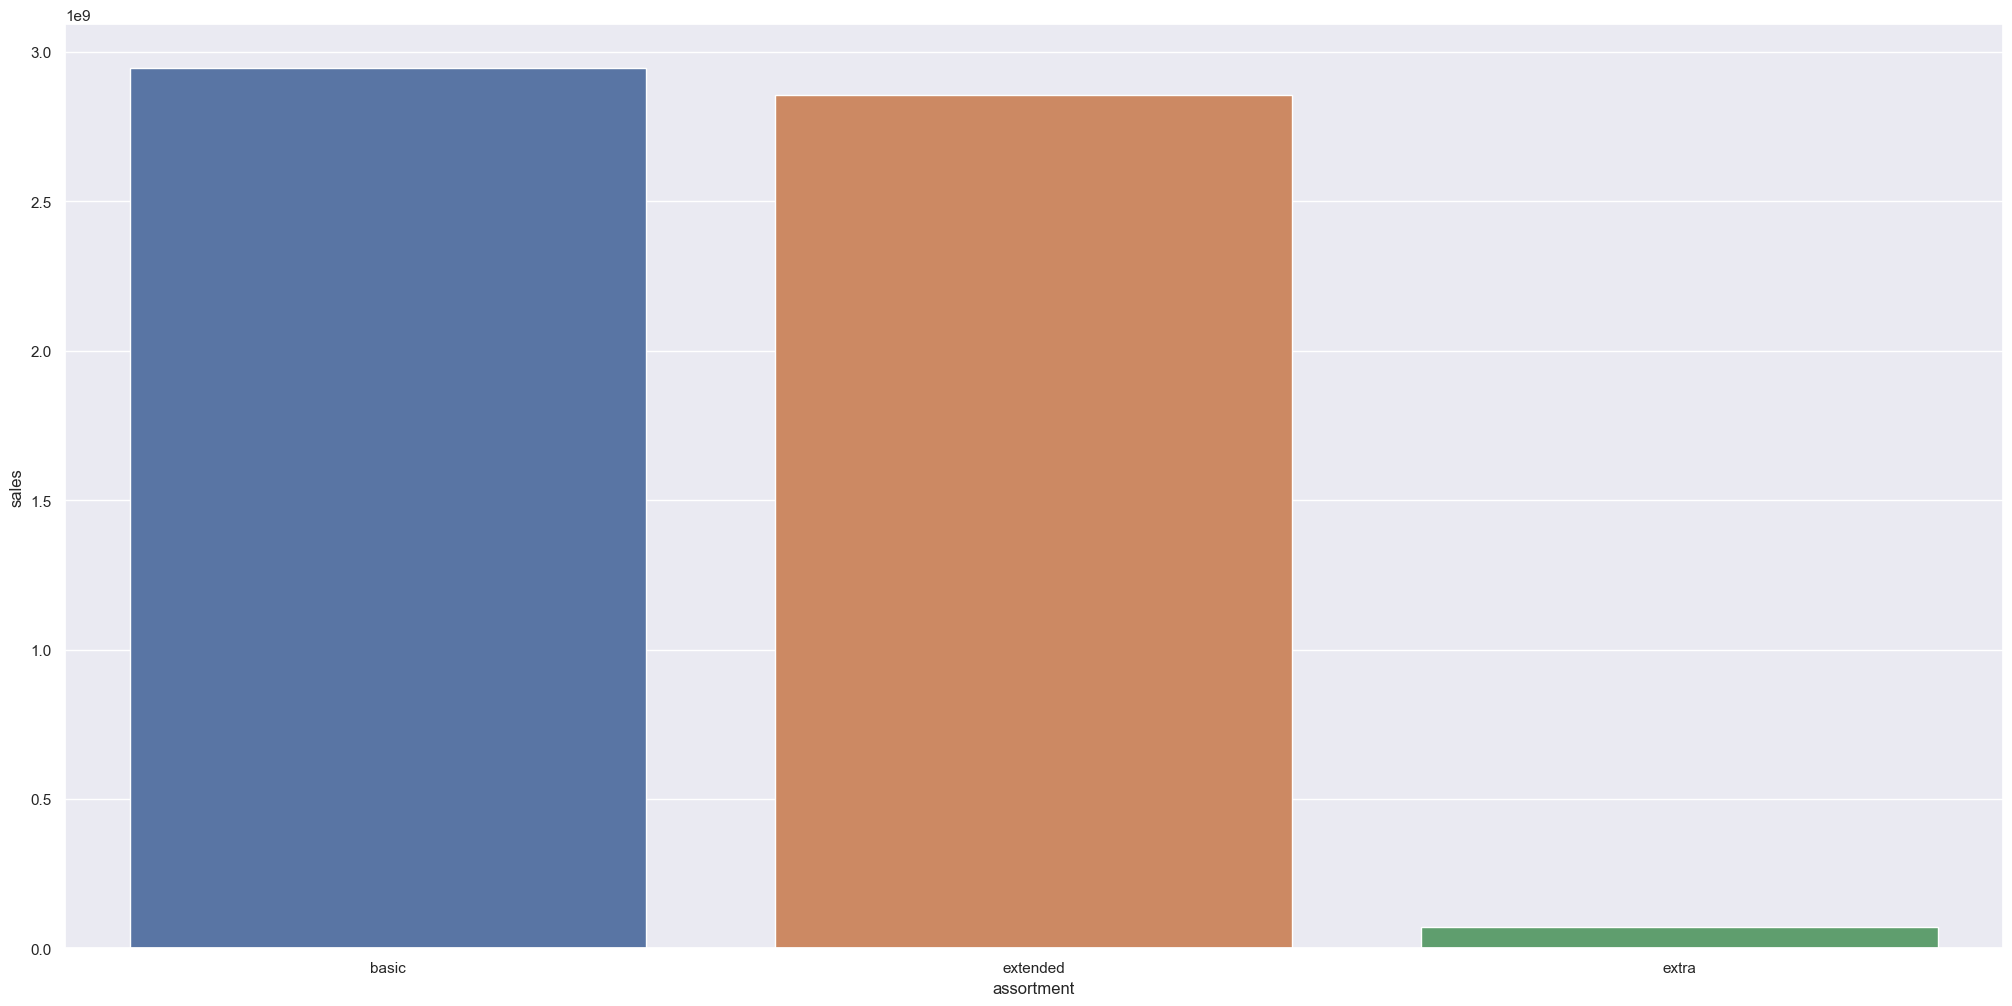

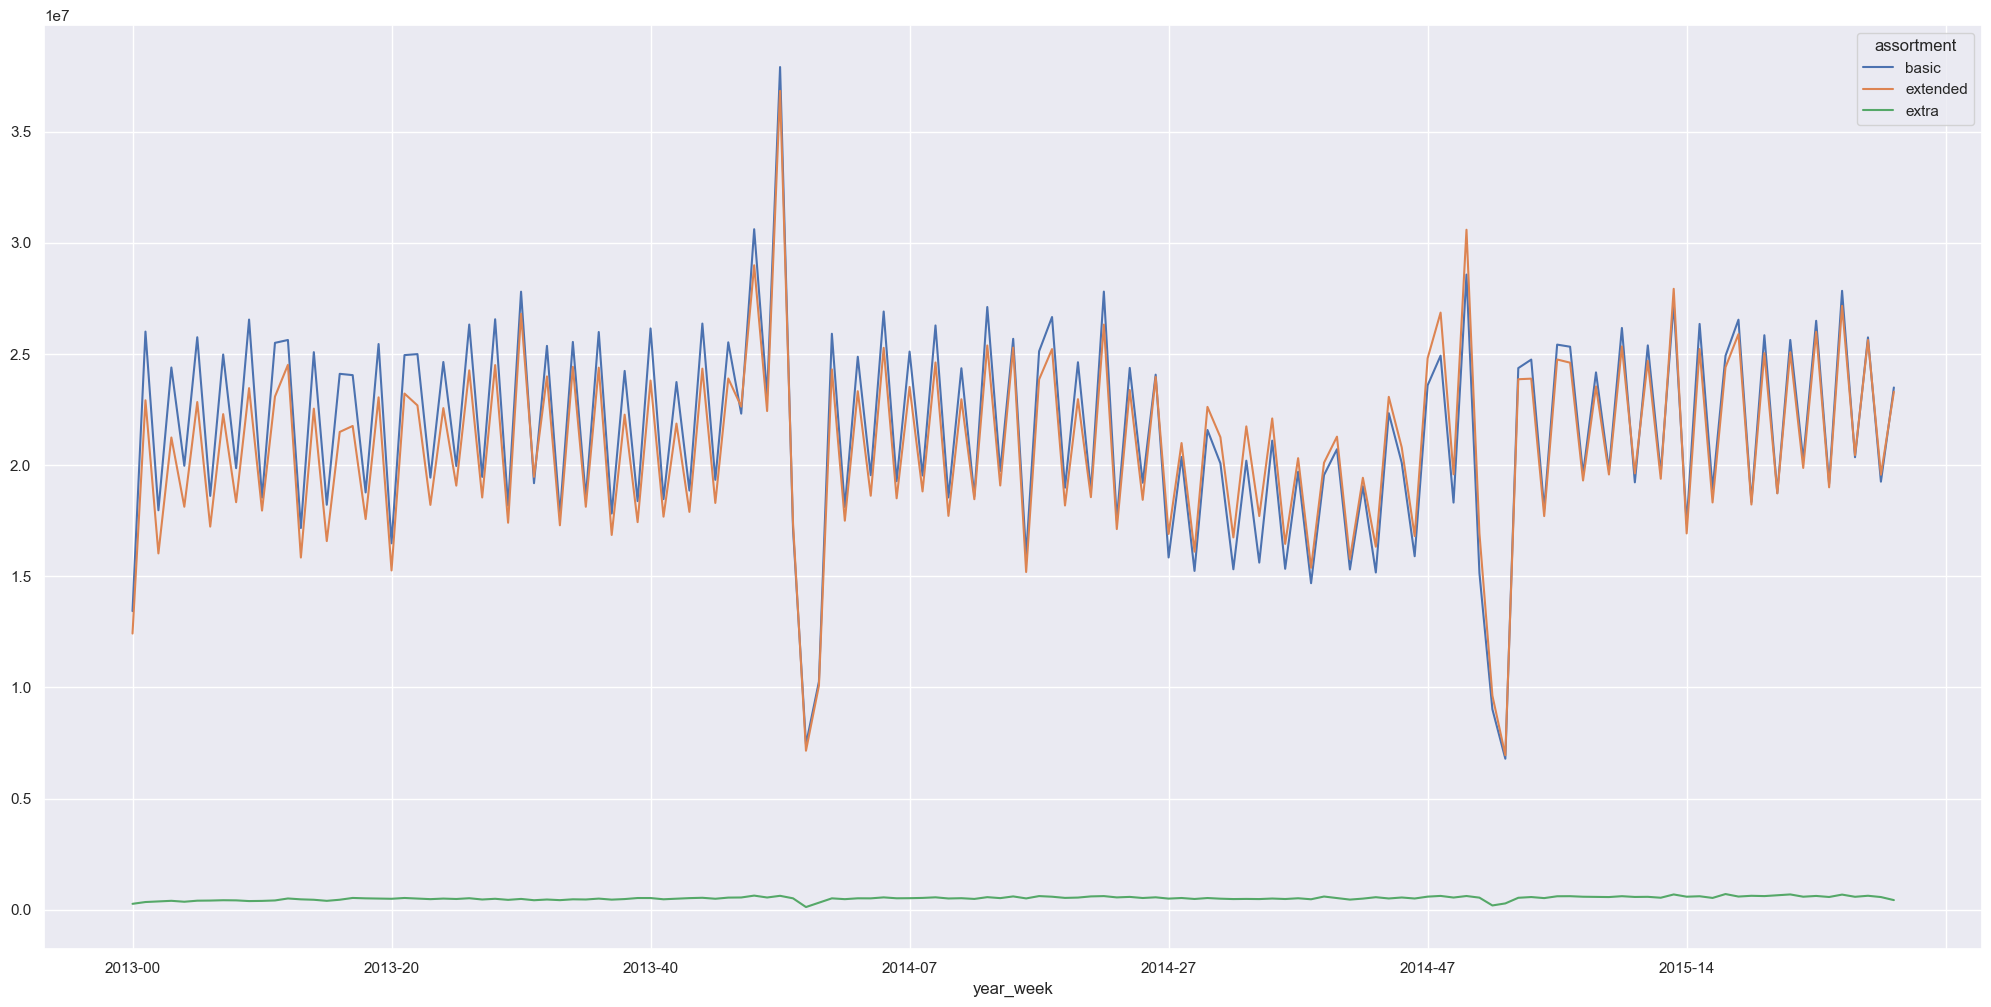

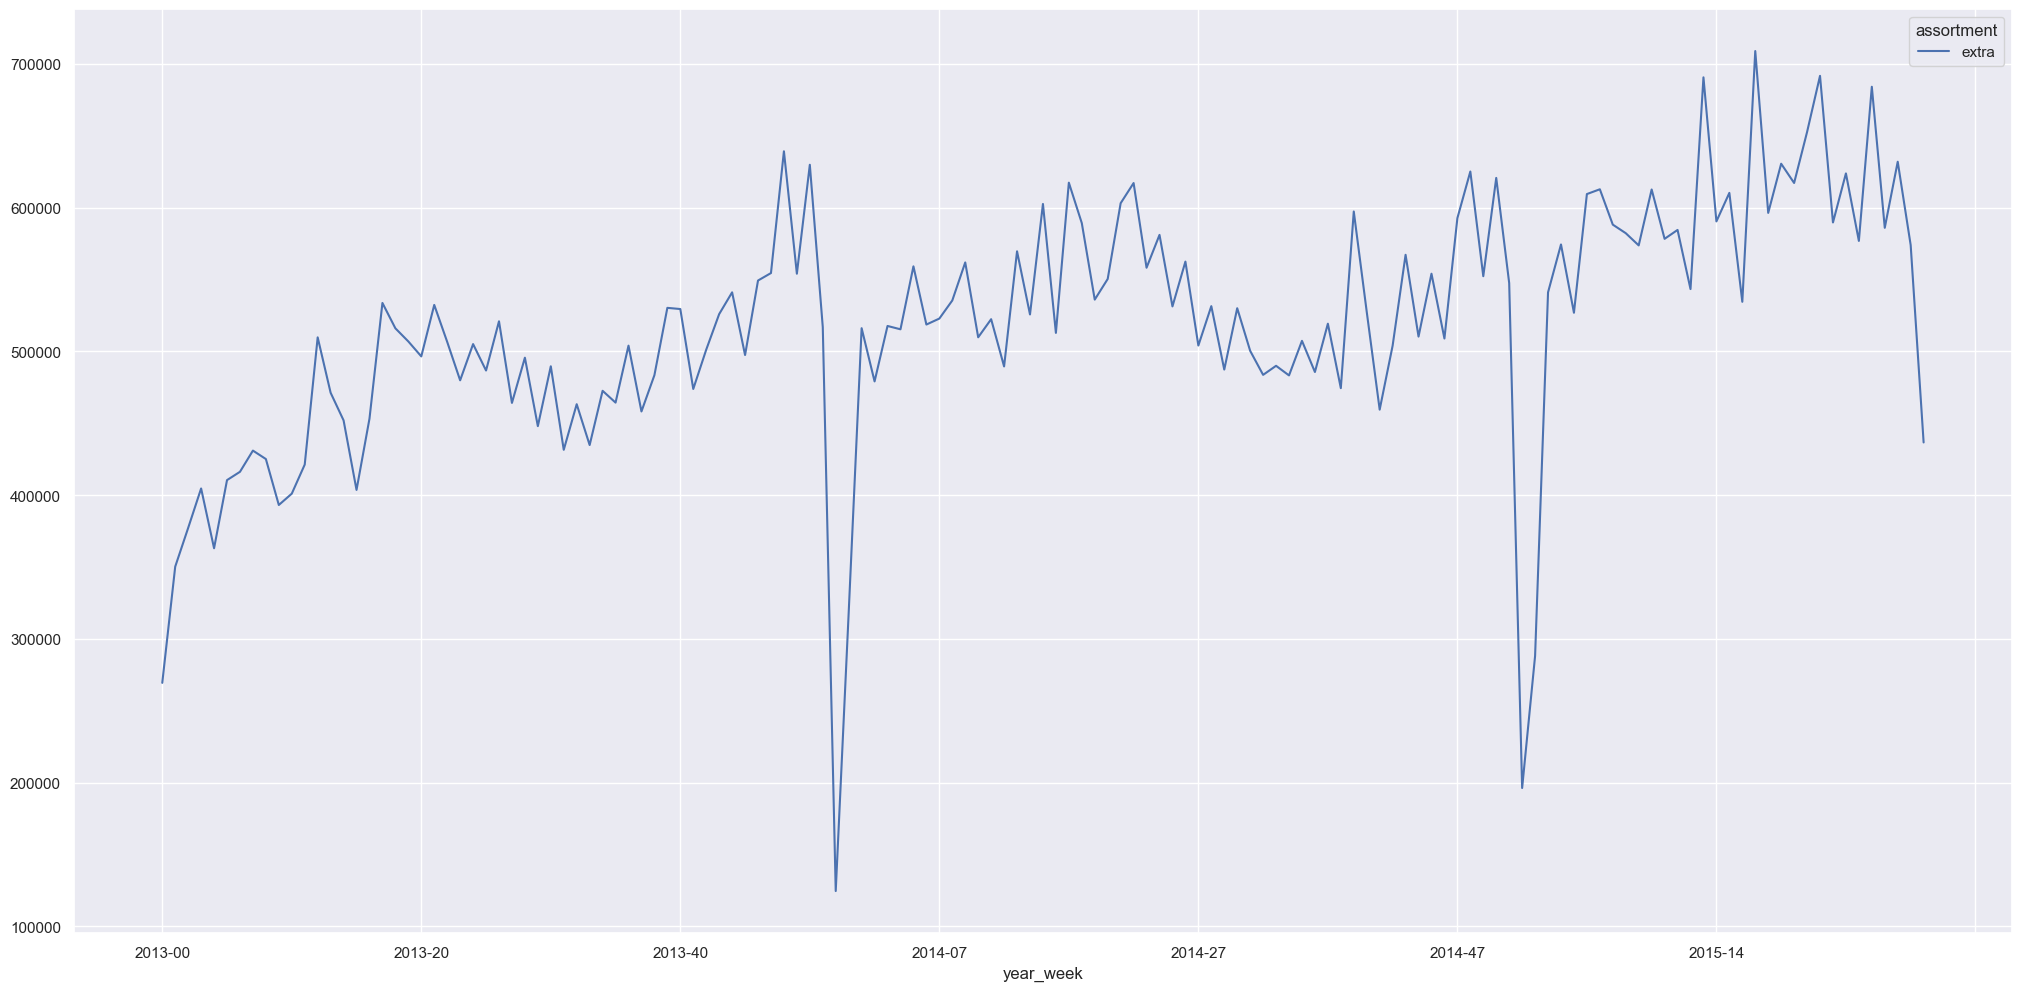

In [29]:
# Cria plot de barras das vendas por tipo de assortment
aux01 = df4[['sales', 'assortment']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux01);

# Cria distribuição das vendas por assortment a cada semana do ano
aux02 = df4[['sales', 'assortment', 'year_week']].groupby(['assortment', 'year_week']).sum().reset_index()
aux02.pivot( index='year_week', columns='assortment', values='sales').plot();

# Cria distribuição para analisar apenas assotment do tipo 'extra'
aux3 = aux02[aux02['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


#### H2.Lojas com competidores mais proximos deveriam vender menos.
FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\yago2\AppData\Local\Temp\ipykernel_11820\1228604286.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


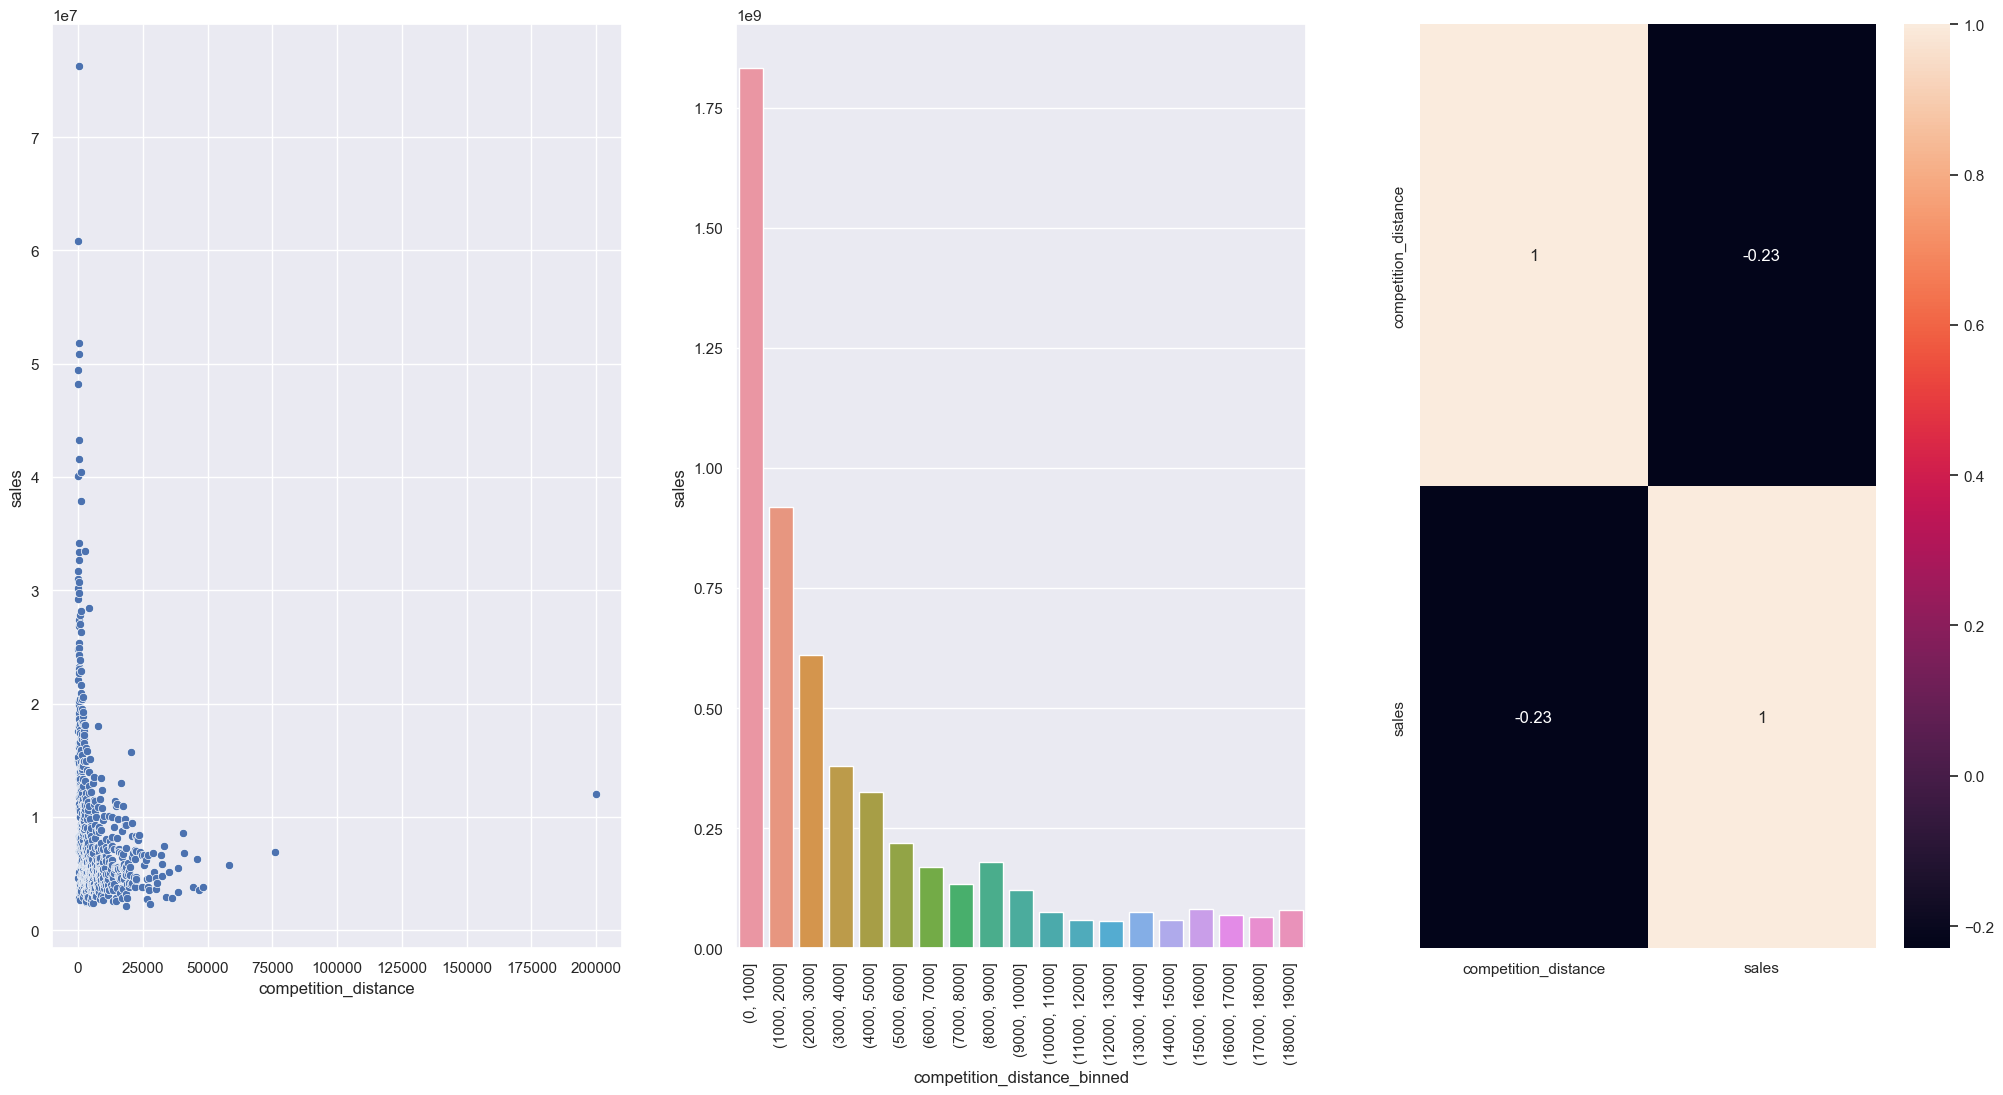

In [30]:
# Agrupa as vendas pela distancia do competidor mais proximo
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
# Cria uma grafico scatter das vendas pela distancia do competidor
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
# Cria uma lista de bins para melhor visualização dos intervalos de vendas pela distancia do competidor no grafico de barras
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
# Cria grafico que mostra a força da correlação( Correlação -0,23 = Quanto maior a distancia do competidor menor a venda)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### H3.Lojas com competidores á mais tempo deveriam vender mais.
FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.


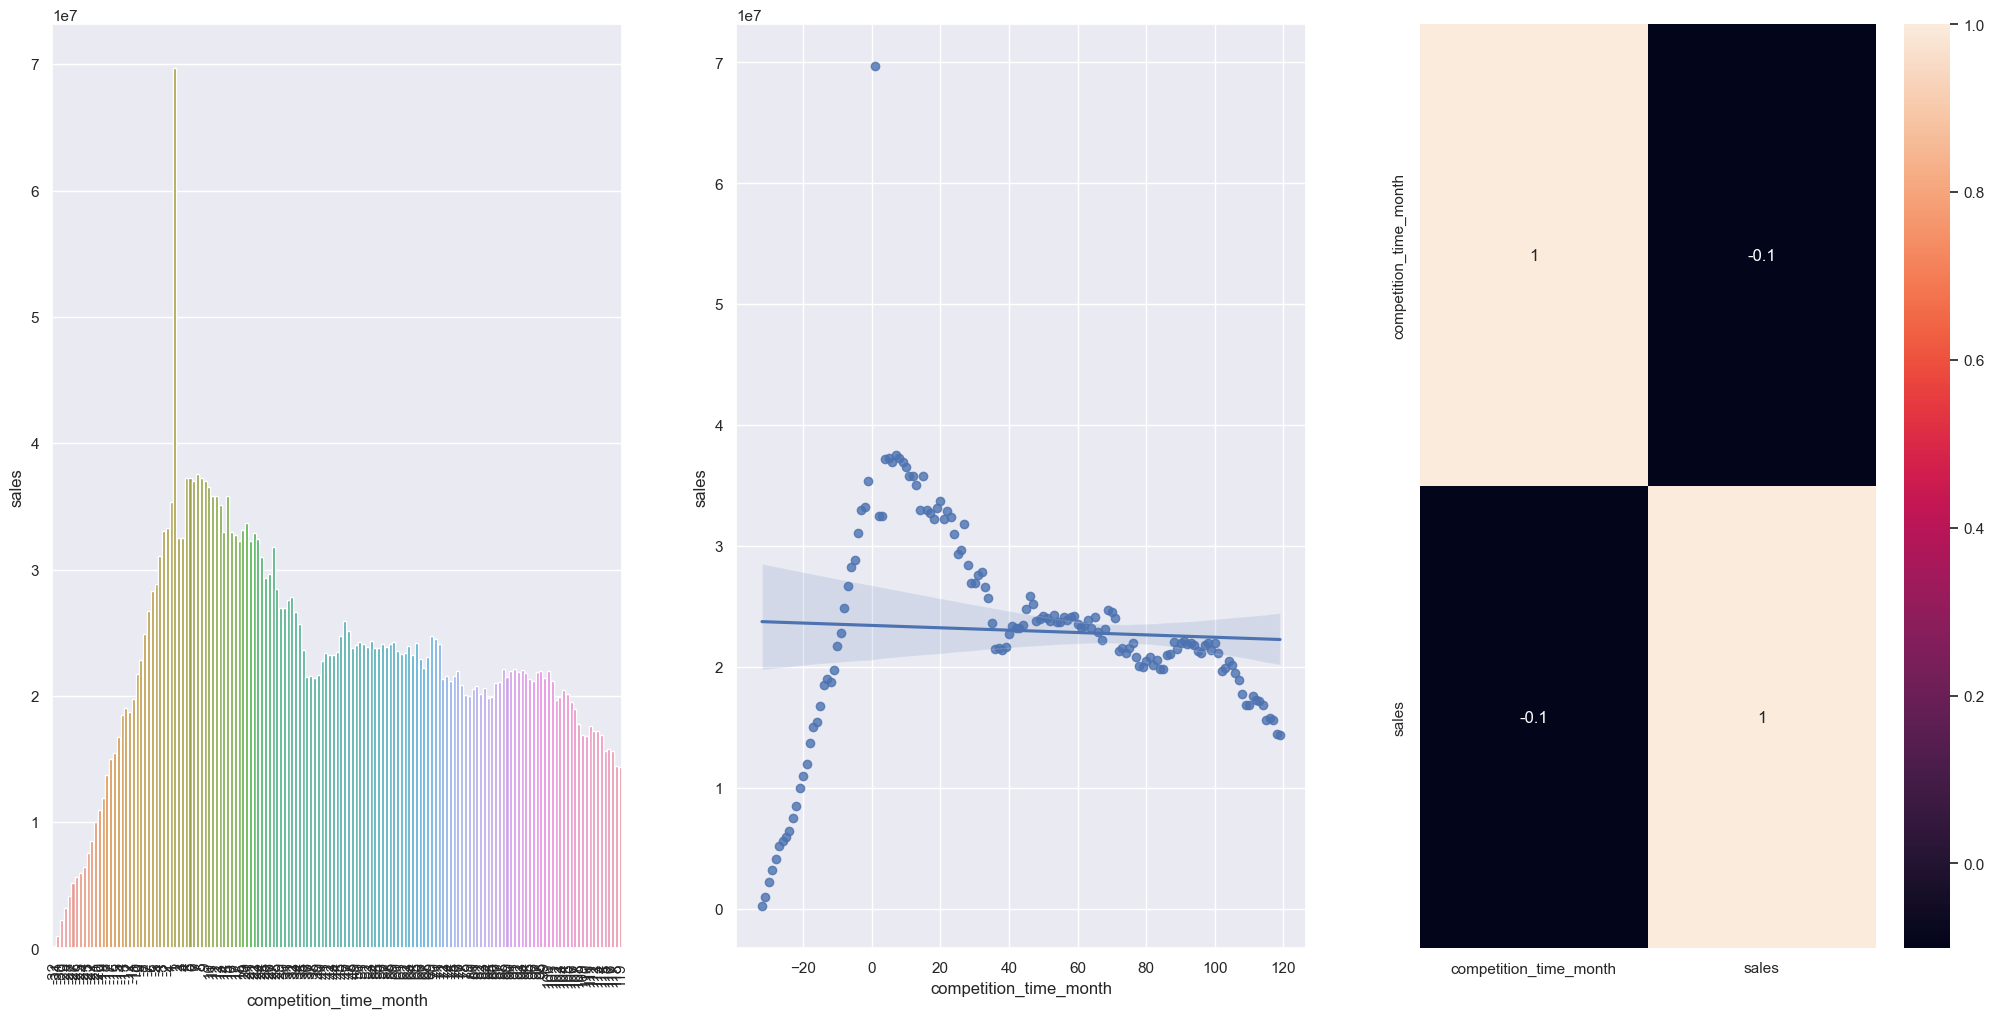

In [31]:
plt.subplot( 1, 3, 1 )
# Cria barplot com as vendas e mês em que o competidor começou a vender,apenas no primeiros 120 meses.
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
# Cria a distribuição com linhas de tendencia  
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
# Cria grafico que mostra a força da correlação( Correlação -0,1 = Lojas com competidores a mais tempo vendem menos)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );



#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao


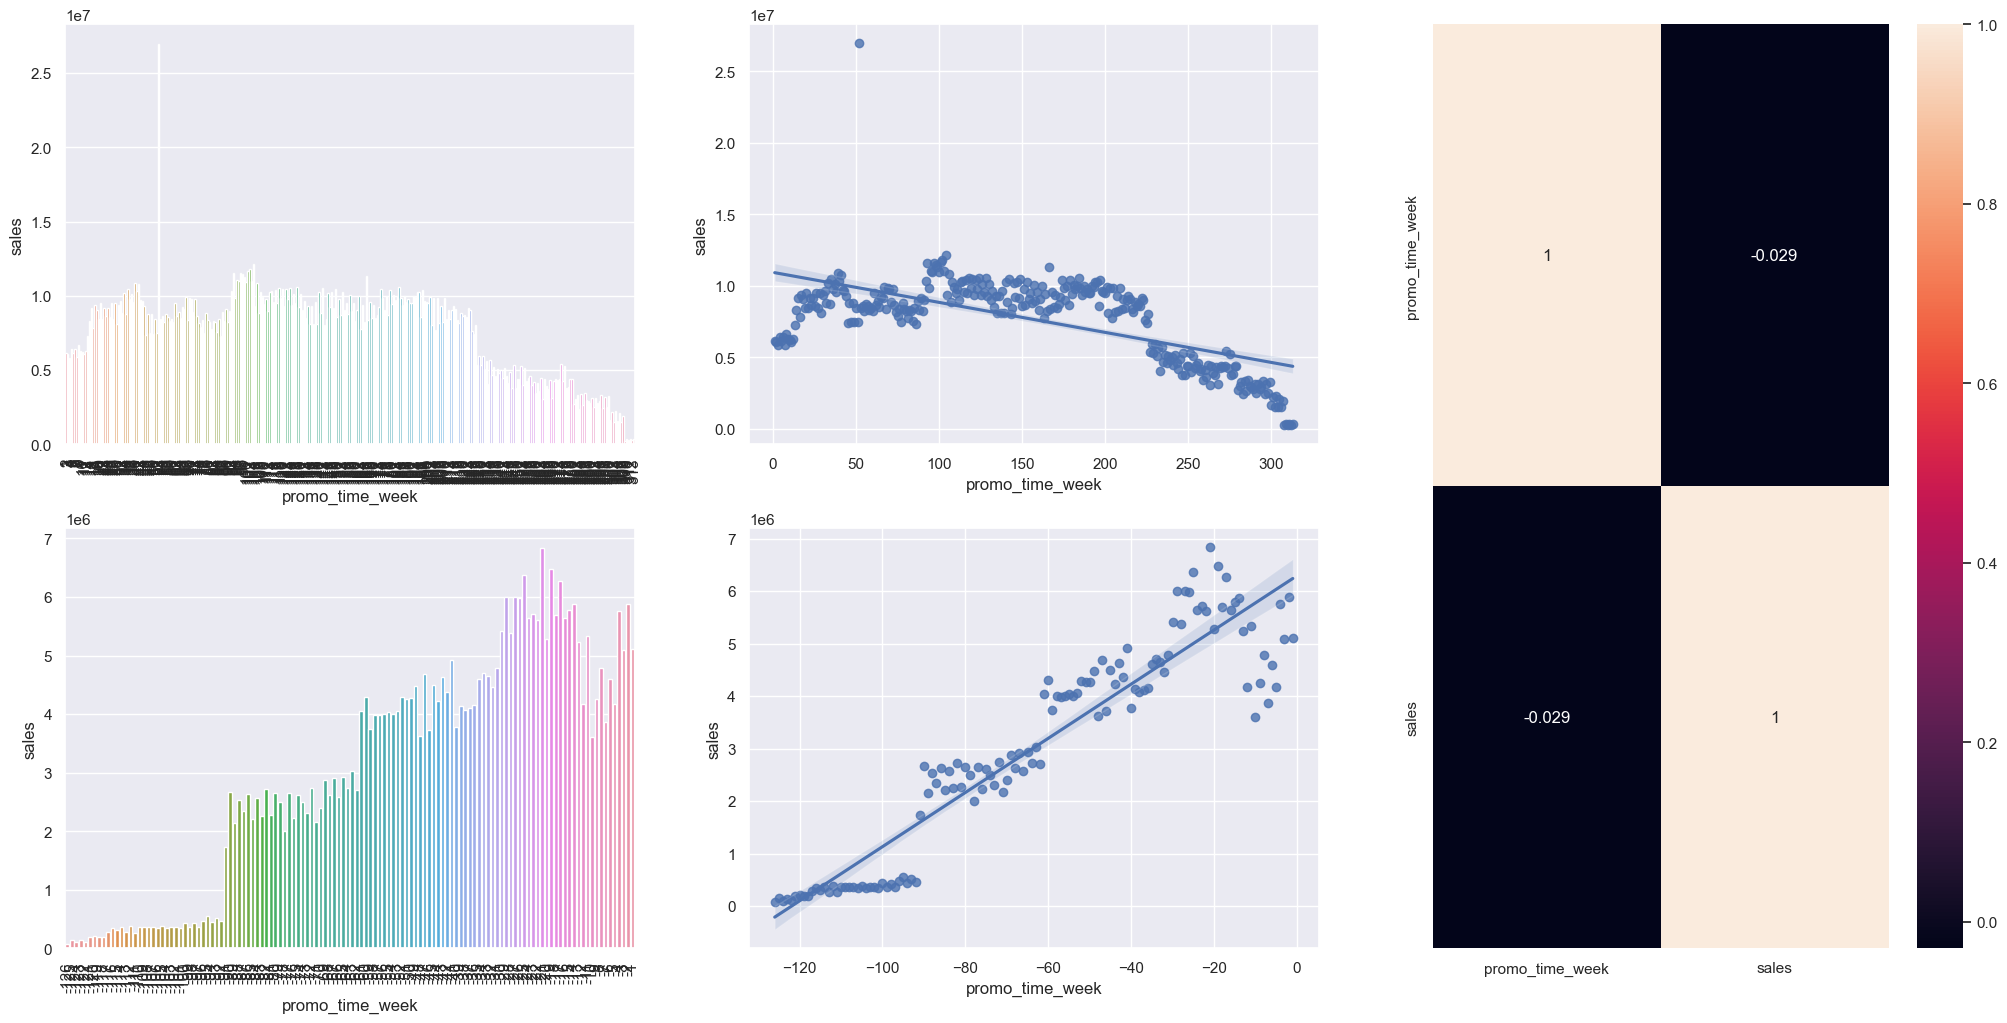

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

# Cria um grip para exibição dos dados
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
# Recorte no periodo de promo extendido
aux2 = aux1[aux1['promo_time_week'] > 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Cria uma grafico de tendencia para promo extendido
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
# Recorte no periodo de promo regular
aux3 = aux1[aux1['promo_time_week'] < 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

# Cria uma grafico de tendencia para promo extendido
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

 #### H5. Lojas com mais dias de promoção deveriam vender mais.


#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
FALSA Lojas com mais promocoes consecutivas vendem menos

In [33]:
# Agrupa as vendas pelos dois tipos de promoçao
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


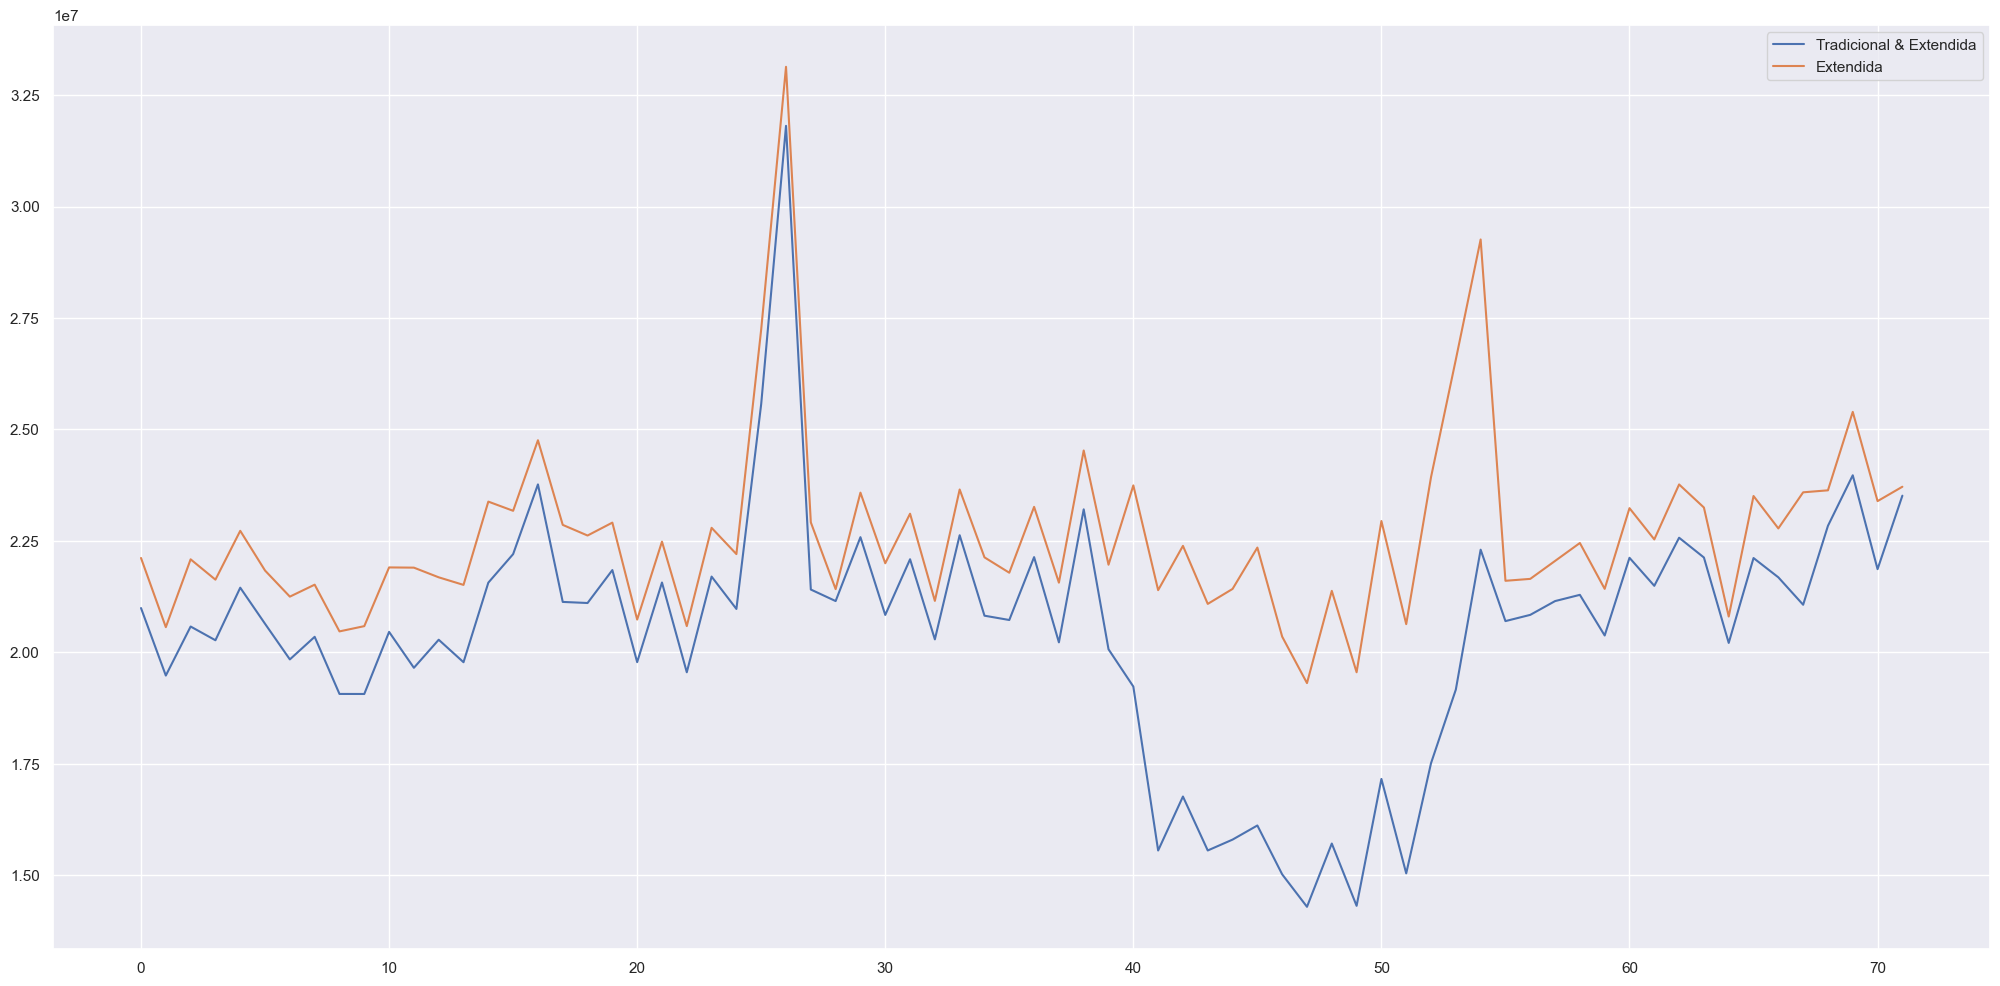

In [34]:
# plota as lojas que tiveram promoçao e extensao
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# Plota as lojas que tiveram promoçao sem extensao
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


#### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos.

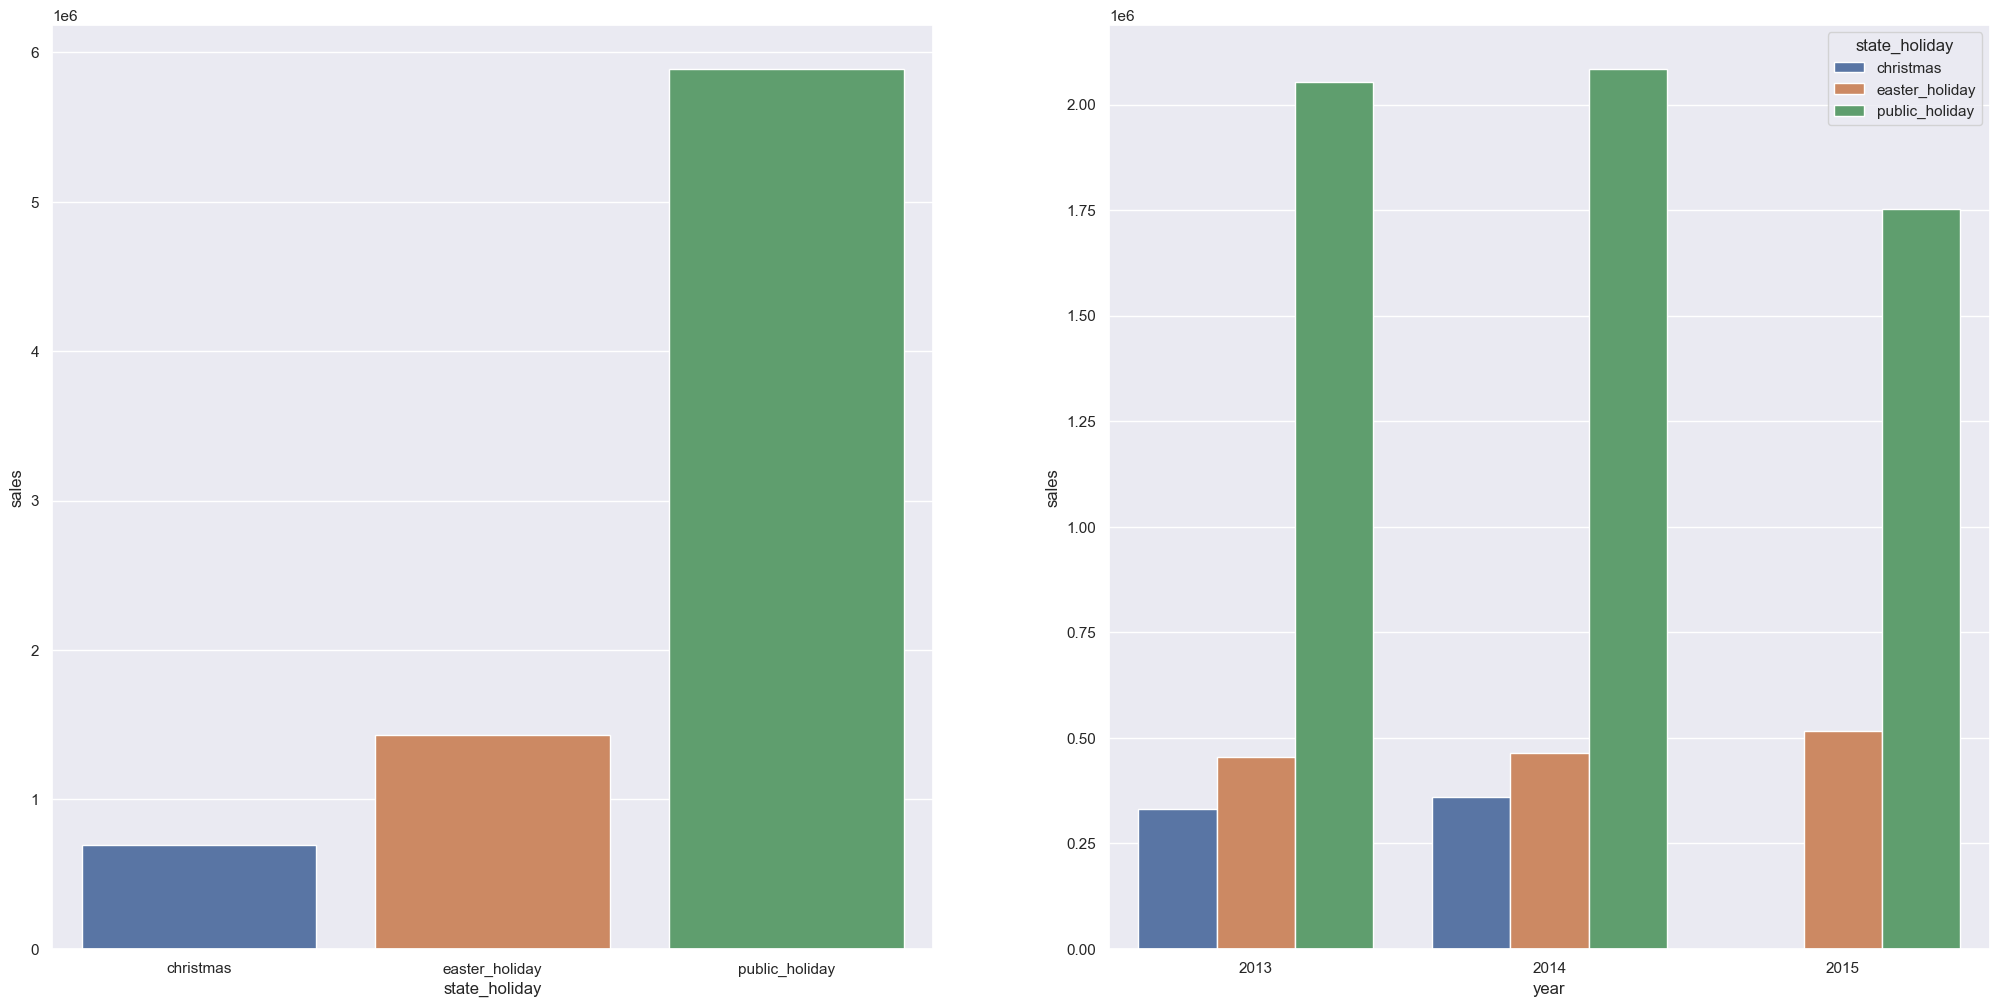

In [35]:
# Elimina os dias regulares para identificar os feriados
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
#Plota grafico das vendas por feriado
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
# Plota grafico de vendas por feriado e ano
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### H9. Lojas deveriam vender mais ao longo dos anos.
FALSA Lojas vendem menos ao longo dos anos

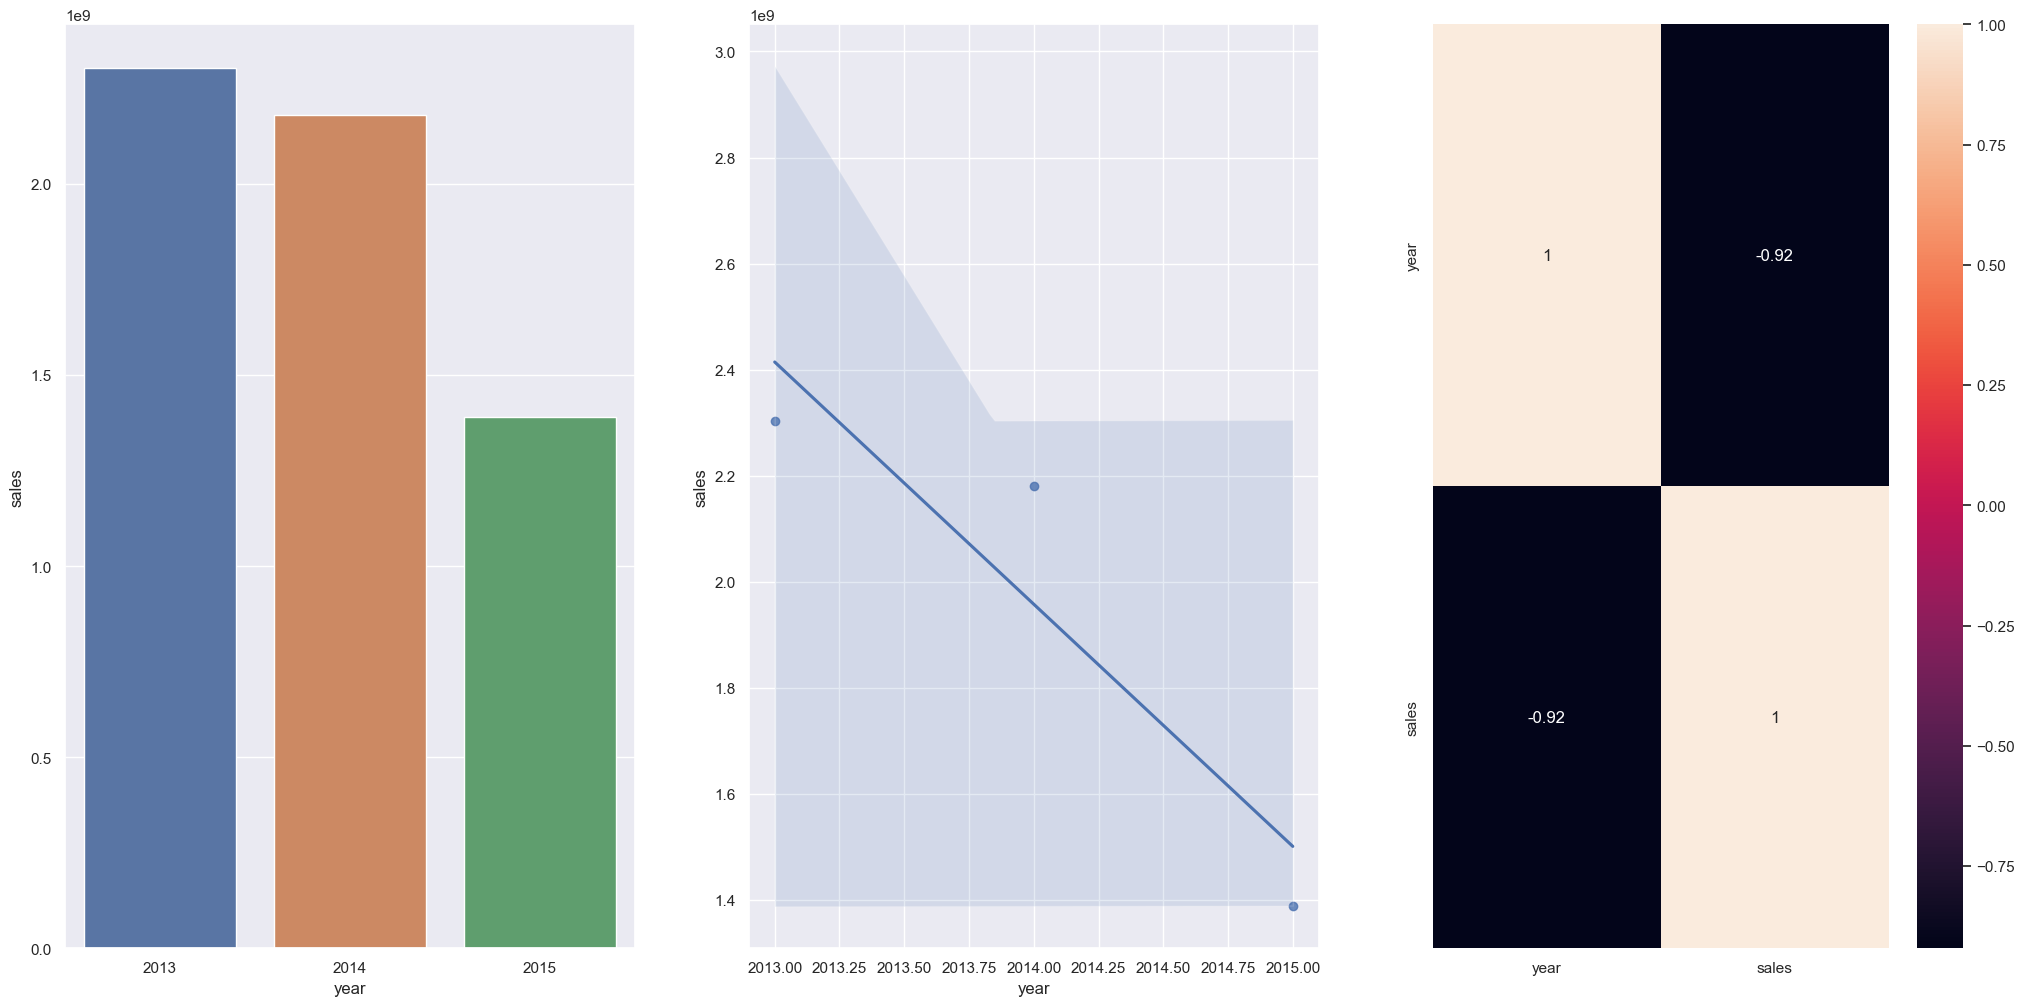

In [36]:
# Agrupa vendas por anos
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
# Grafico de vendas por ano
sns.barplot( x='year', y='sales', data=aux1 );

# Grafico de tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

# Grafico de correlacao
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

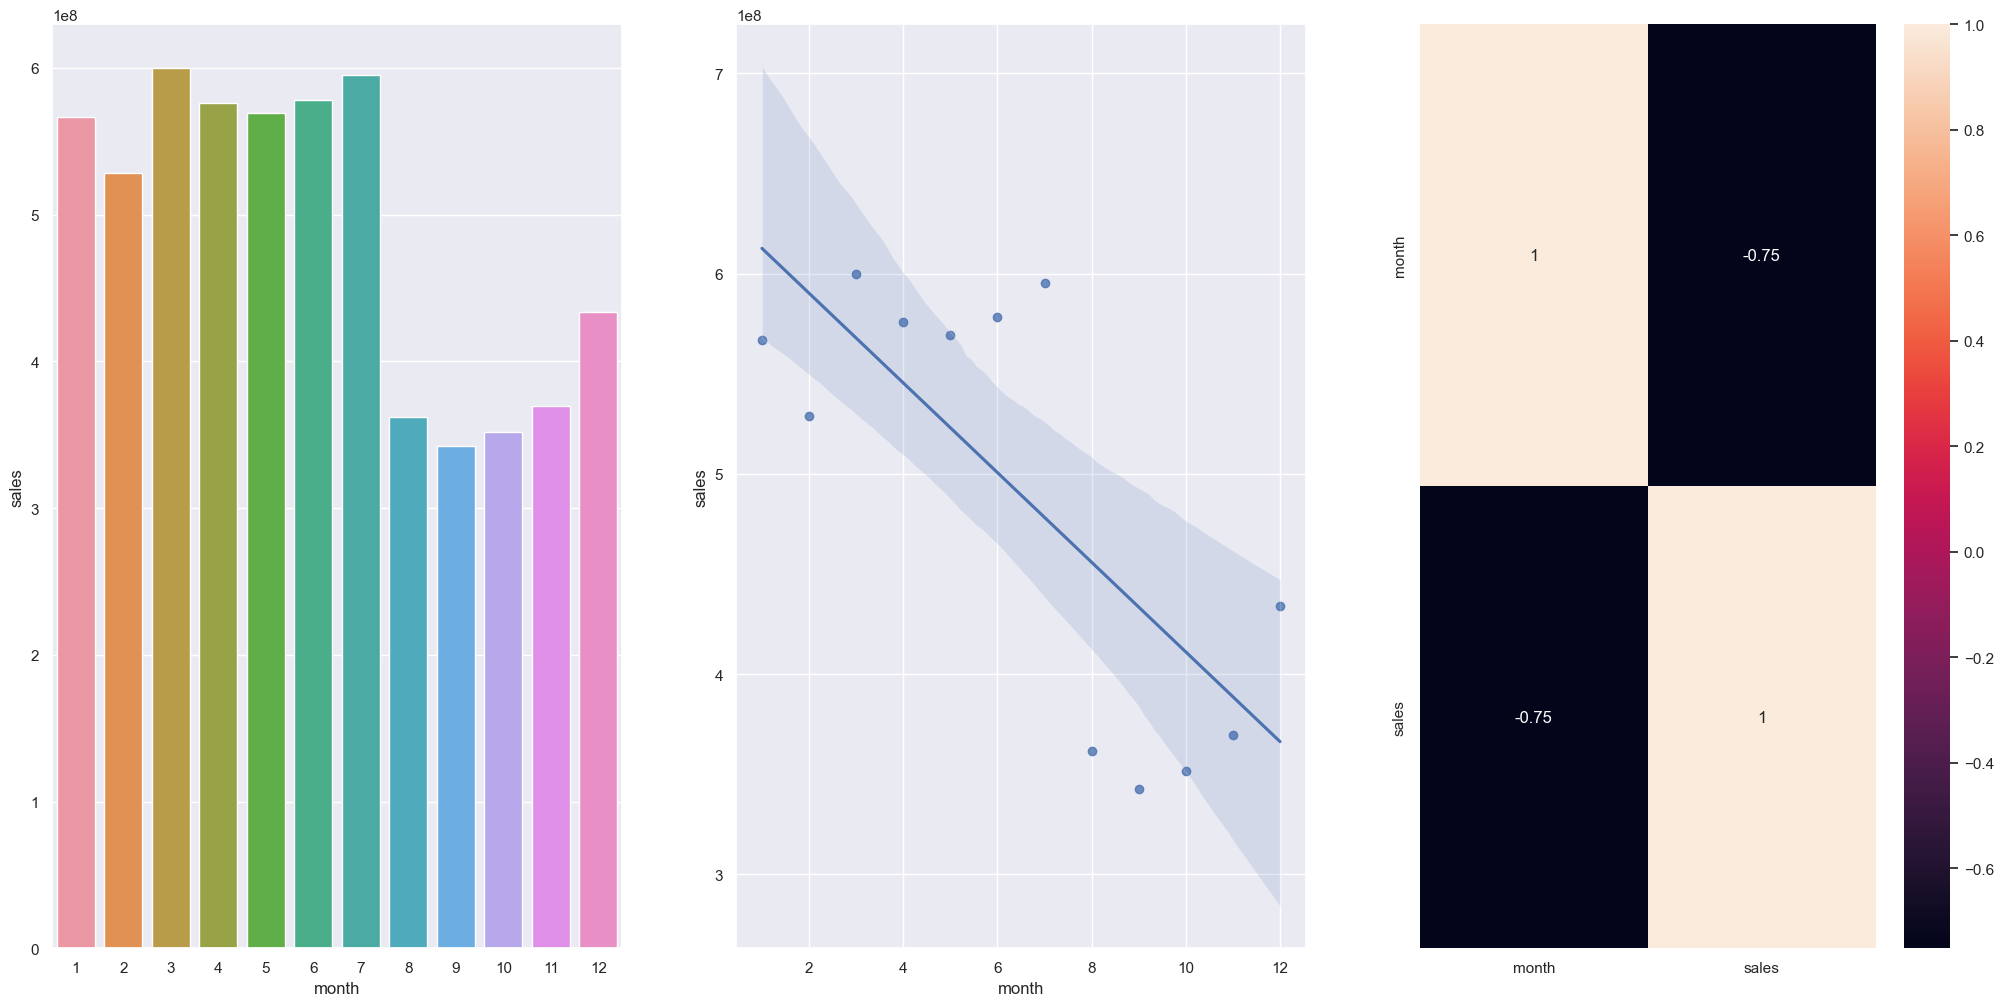

In [37]:
# Agrupa vendas por mes
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
# Grafico de vendas por ano
sns.barplot( x='month', y='sales', data=aux1 );

# Grafico tendencia de vendas por mes
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

# Grafico de correlacao de vendas por mes
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.

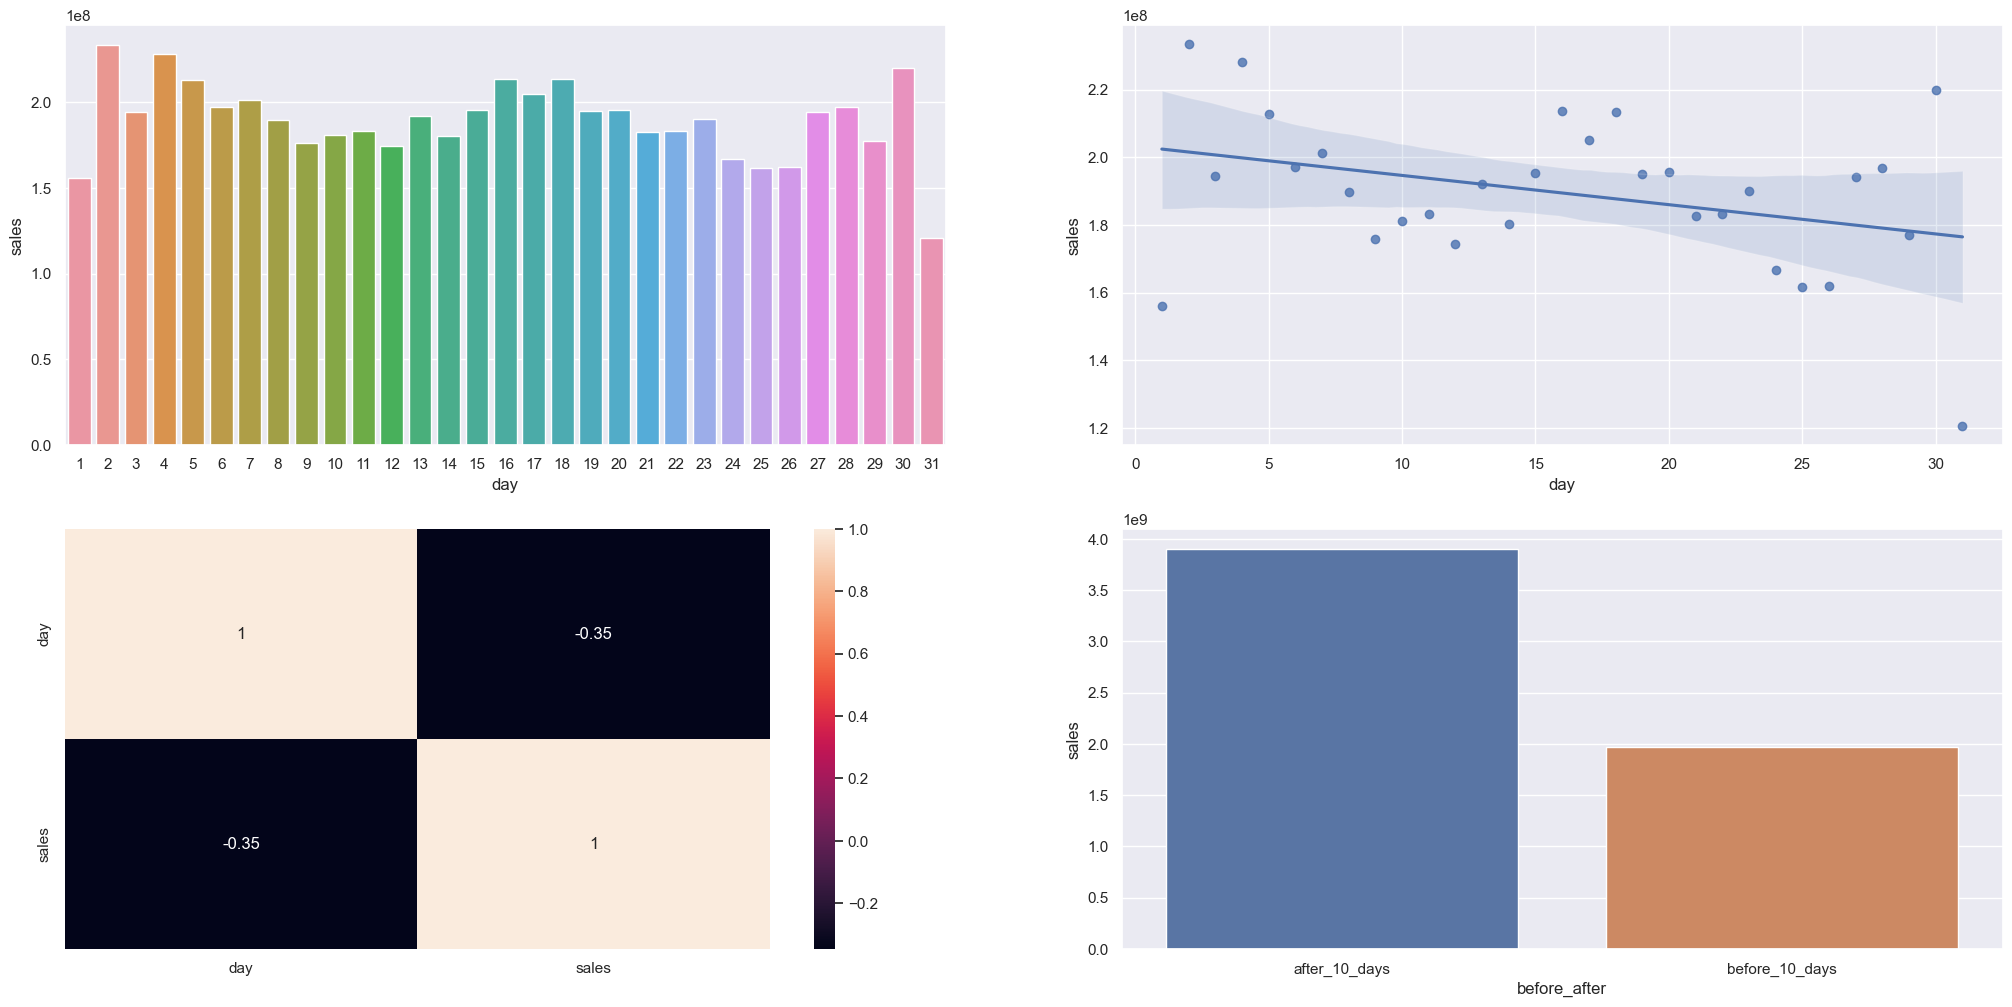

In [38]:
# Agrupa vendas por dia
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# Filtra periodo anterior e posterior ao dia 10 de cada mes
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### H12. Lojas deveriam vender menos aos finais de semana.
VERDADEIRA Lojas vendem menos nos final de semana

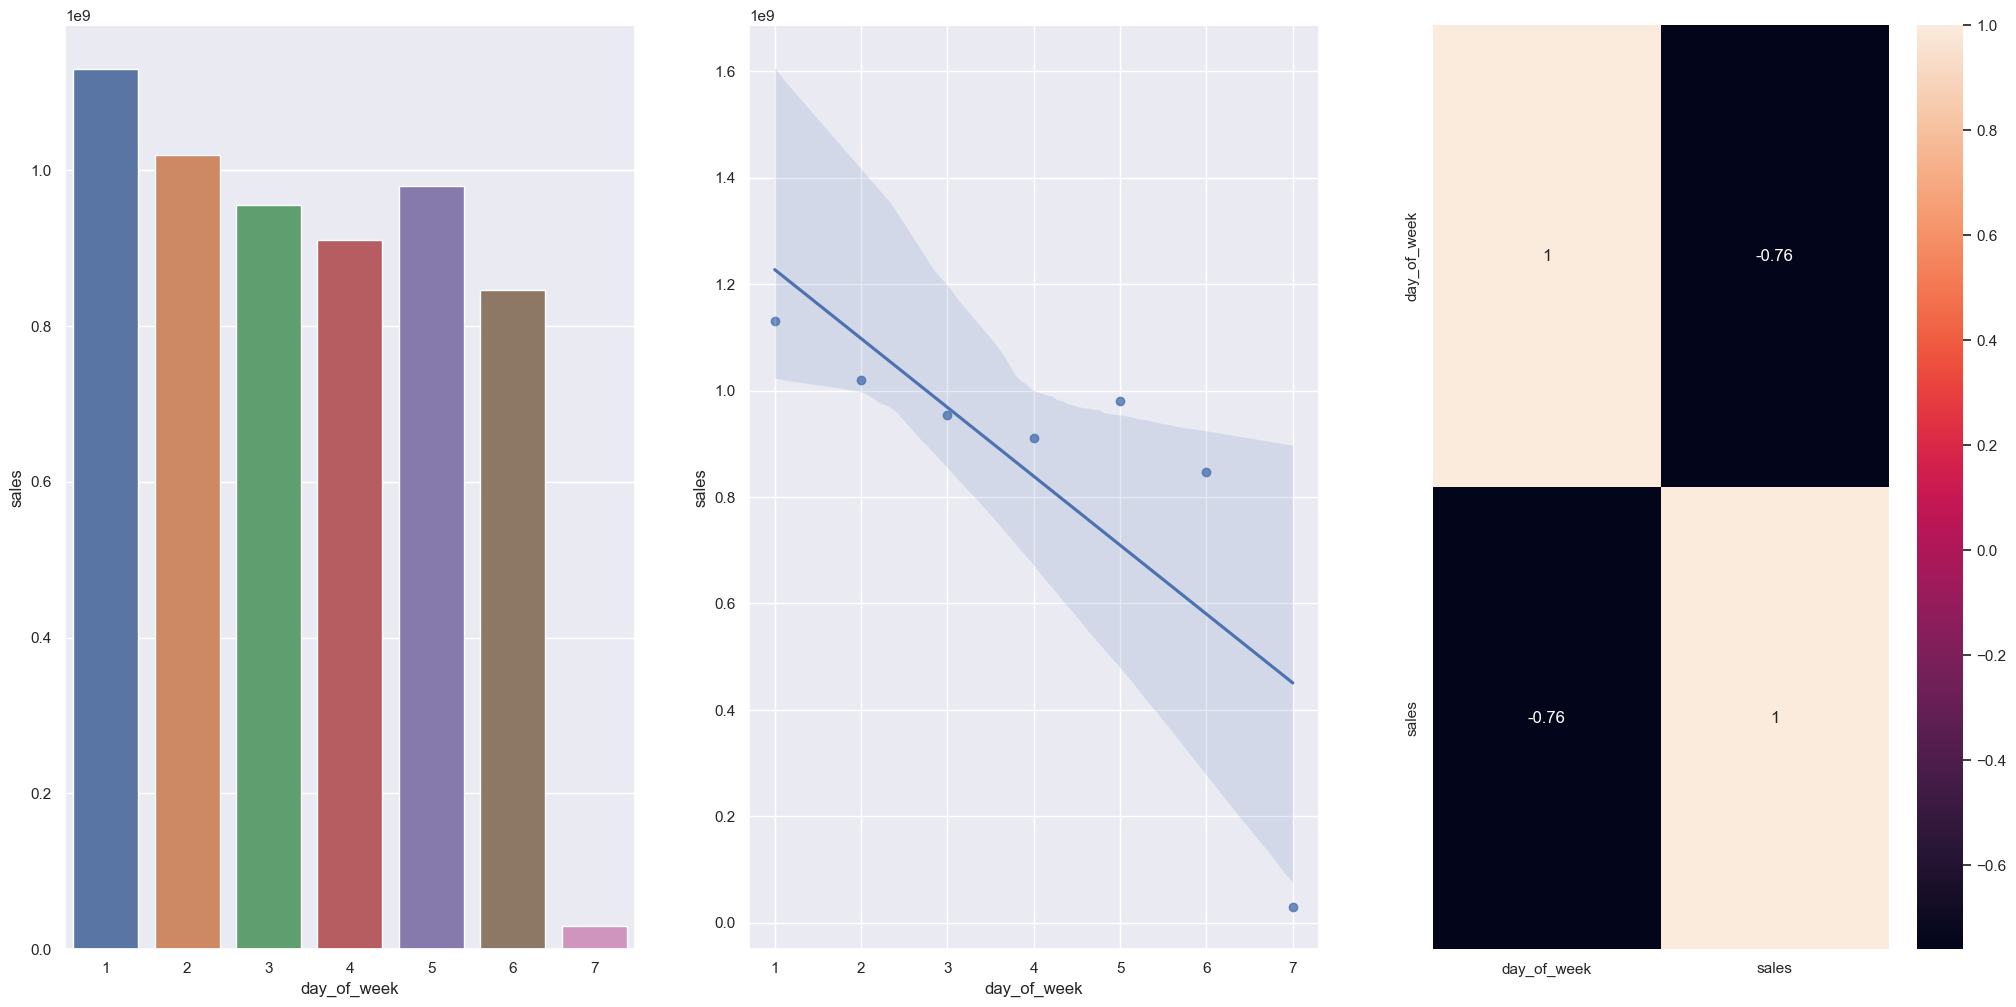

In [39]:
# Agrupa vendas por dia da semana
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### H13. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e
Agosto.

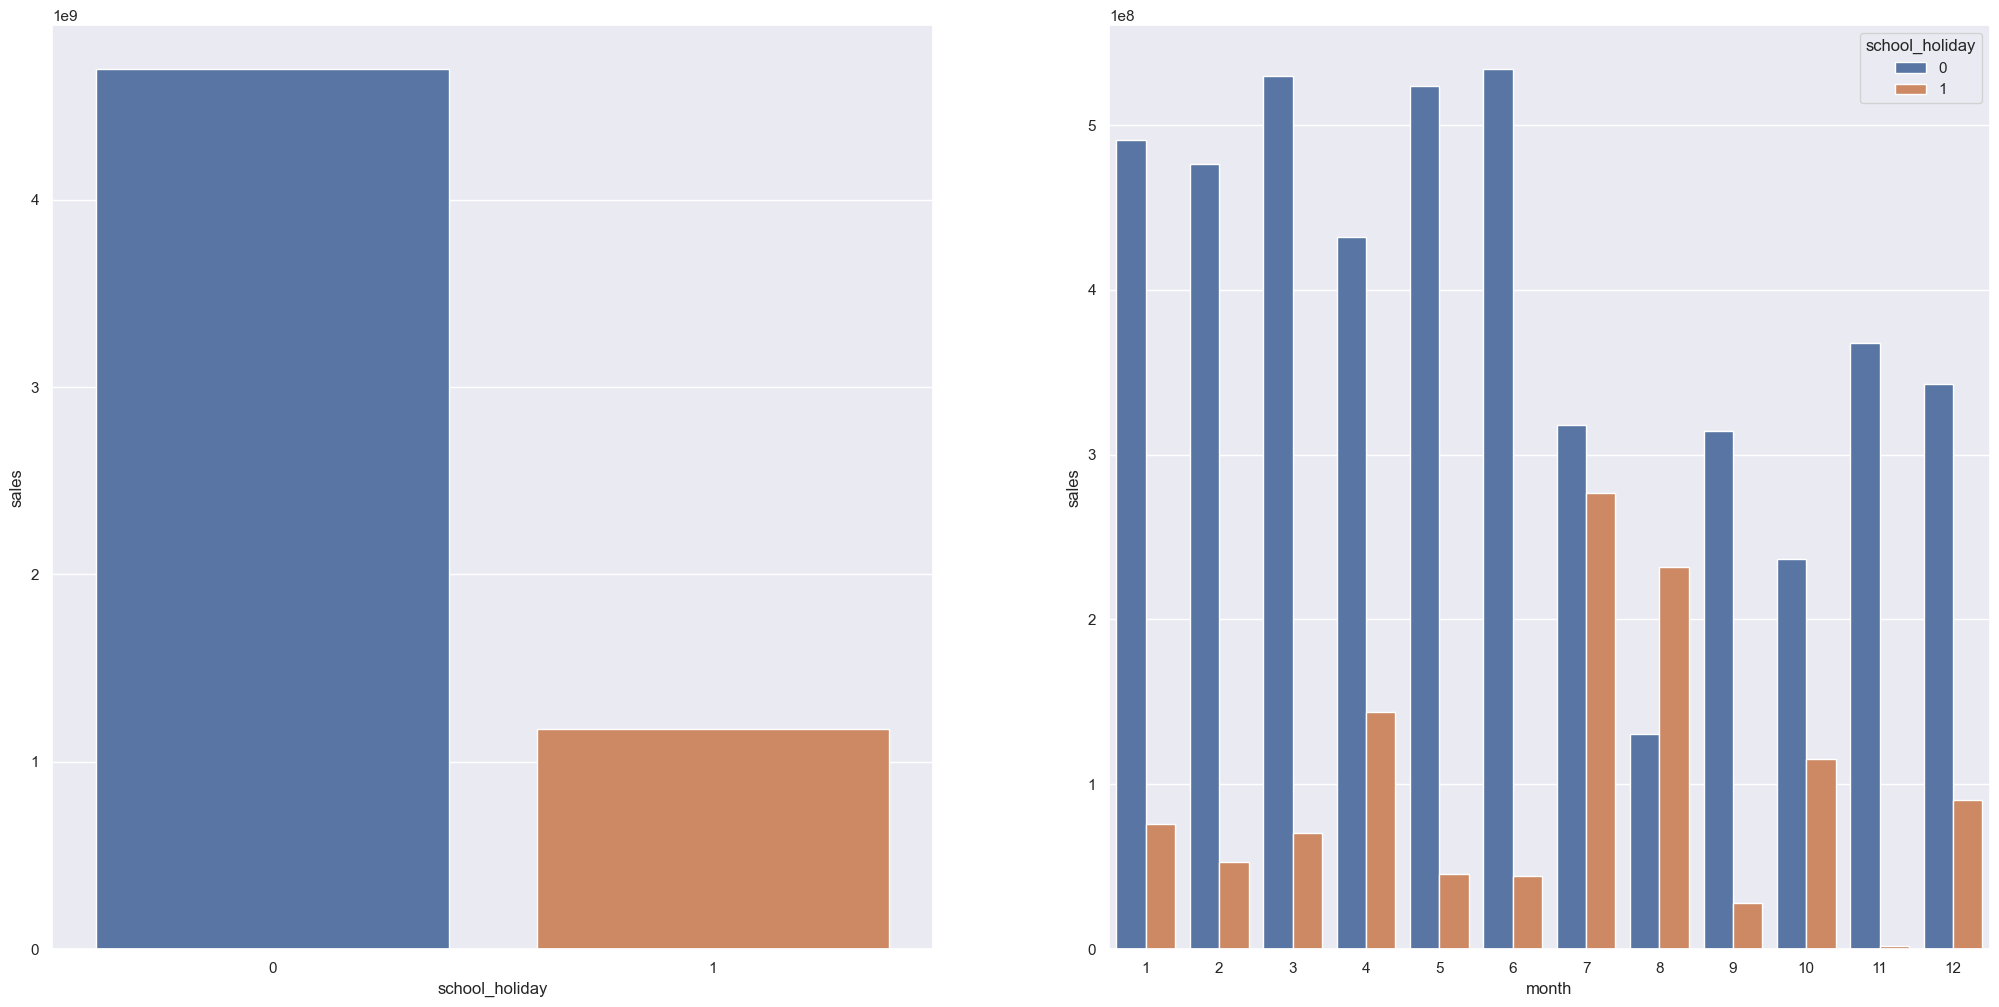

In [40]:
# Agrupa vendas por feriado escolar
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

# Agrupa vendas por feriado escolar por meses
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 1, 2, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


#### 4.2.1. Resumo das Hipoteses

In [41]:
# Cria uma tabela com resumo das hipoteses levantadas e suas correlaçoes
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3 Analise Multivariada

####  4.3.1. Numerical Attributes

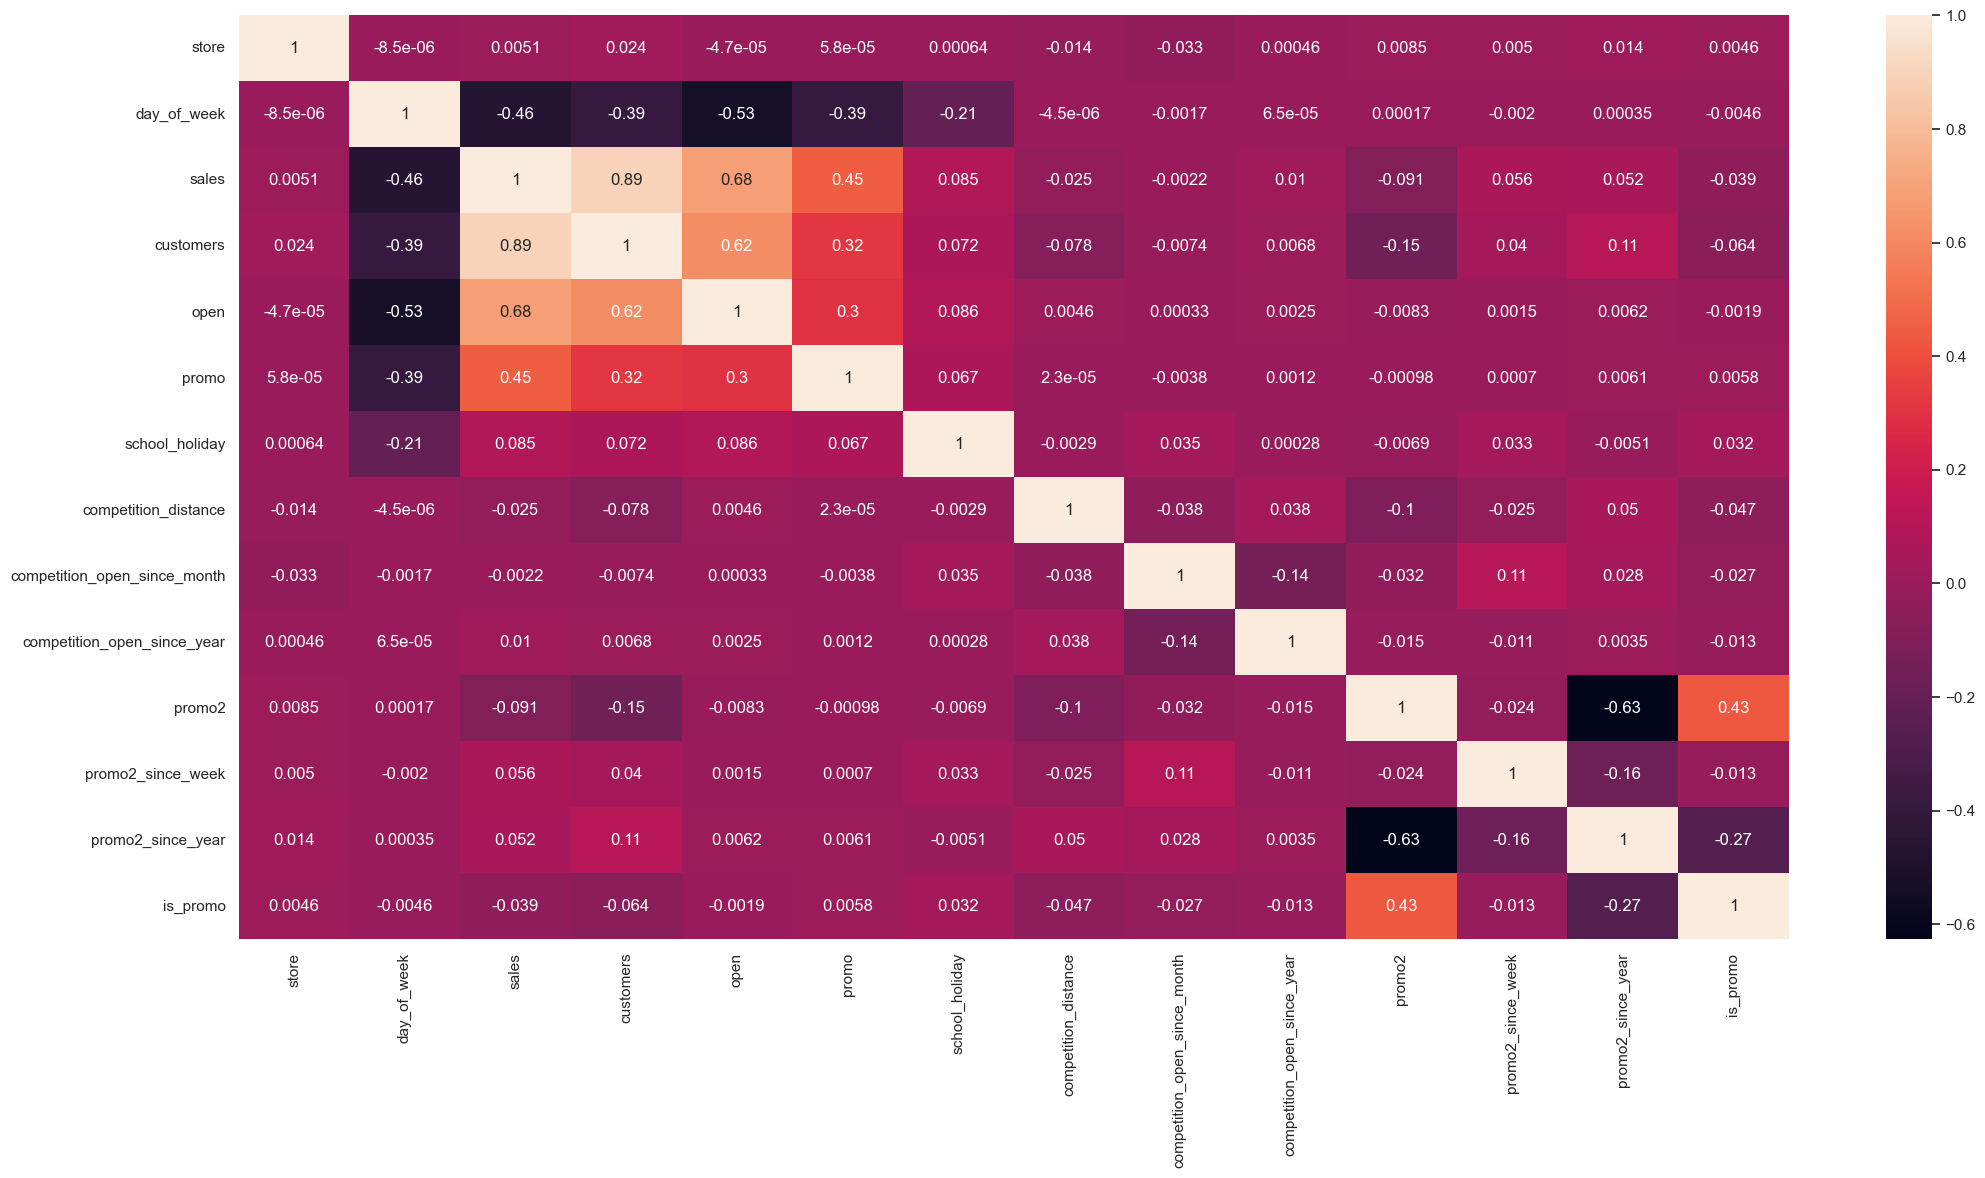

In [42]:
# Grafico de correlação entre as variaveis numericas
correlation = num_atributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


#### 4.3.2. Categorical Attributes

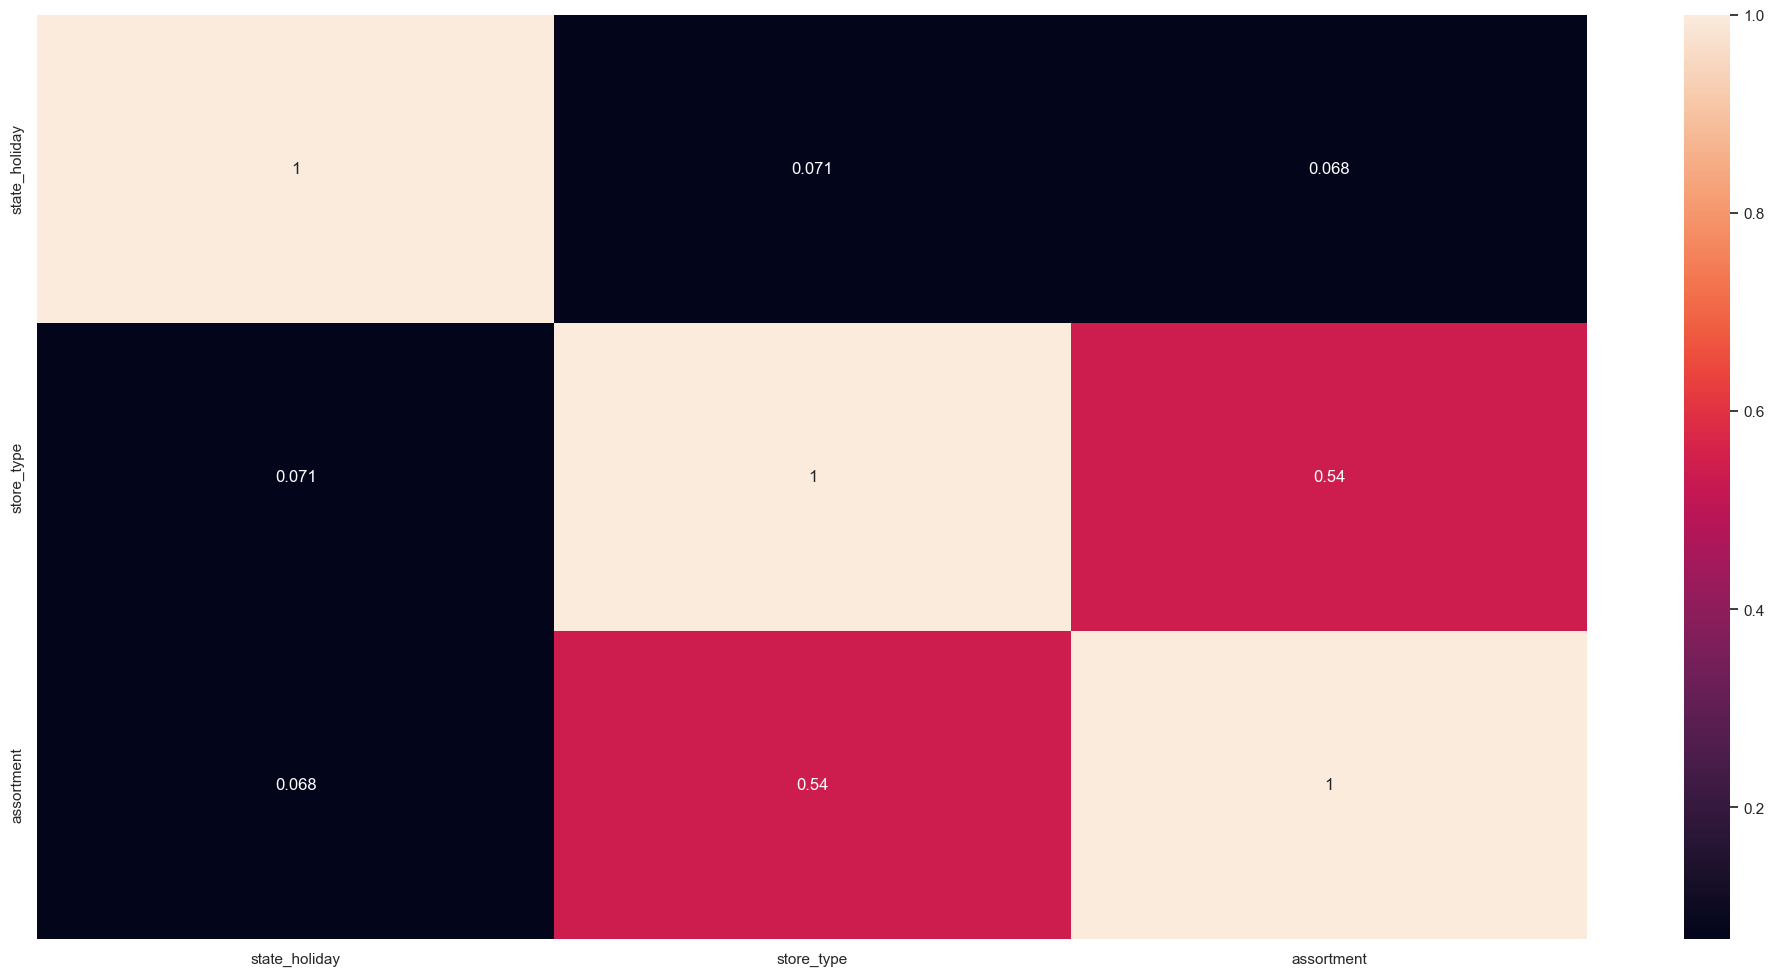

In [43]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );


# 5.0 PASSO 05 - DATA PREPARATION


In [44]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.2. Rescaling


In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance, Possui outliers = rs
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month, Possui outliers = rs
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week, Não possui outliers = mms
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year, Não possui outliers = mms
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. Transformacao

### 5.3.1 Encoding

In [46]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )


### 5.3.2 Response Variable Transformation

In [47]:
#Aplicada transformação logaritima na variavel resposta
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation


In [48]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 PASSO 06 - FEATURE SELECTION

In [49]:
df6 = df5.copy()

##  6.1. Split dataframe into training and test dataset

In [50]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [51]:
# Eliminando features originais que criaram derivadas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [52]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


##  6.2. Boruta as Feature Selector

In [54]:
# raining and test dataset for Boruta
# Elimina a data e vendas pois são dados de treino
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [55]:
# Rank de relevancia do boruta
cols_selected = boruta.support_.tolist()

# best features
#Cria uma x_train_fs não vetorizado e remove as data e vendas
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#Seleciona dentro do X_train todas as colunas selecionadas pelo algoritmo dentro de uma lista de colunas
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
# Retorna as colunas não selecionadas como relevantes, retornando uma lista da diferença do total de colunas pelas selecionadas
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 6.3. Manual Feature Selection

In [59]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_cos']

In [60]:
# columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


In [61]:
cols_selected_boruta_full


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_cos',
 'date',
 'sales']